In [4]:
import os
import shutil
import torch
from torch.utils.data import DataLoader
import numpy as np
import argparse

import os
import shutil
import torch
from torch.utils.data import DataLoader
import numpy as np
# import pandas as pd
import argparse
import time
import utils
from engine import *
from model import *
# from torch.utils.tensorboard import SummaryWriter

# Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cycler
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, TwoSlopeNorm, NoNorm, CenteredNorm, Normalize
import matplotlib.cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
import matplotlib.transforms as mtransforms
import matplotlib.ticker
cbformat = matplotlib.ticker.ScalarFormatter()
cbformat.set_powerlimits((-2,2))
import matplotlib.pylab as pylab
from matplotlib import font_manager
font_dirs = ["/home/zhihao/fonts/"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

parser = argparse.ArgumentParser()
parser.add_argument('--debug_mode',action='store_true',help='whether in debug mode')  # set store_true to disable
parser.add_argument('--device',type=str,default='cuda:0',help='')
parser.add_argument('--data_path',type=str,default='../../data/traffic',help='data path')
parser.add_argument('--adj_path',type=str,default='../../data/traffic/sensor_graph/npy',help='data path')
parser.add_argument('--data',type=str,default='pemsd7m',help='data path')
parser.add_argument('--covariates',type=str,default='spd',help='data path')
parser.add_argument('--num_feat', type=int, default=1)
parser.add_argument('--output_dim', type=int, default=1)
parser.add_argument('--num_hidden', type=int, default=32)
parser.add_argument('--node_hidden', type=int, default=12)
parser.add_argument('--time_emb_dim', type=int, default=12)
parser.add_argument('--layer', type=int, default=5)
parser.add_argument('--k_t', type=int, default=3)
parser.add_argument('--k_s', type=int, default=2)
parser.add_argument('--gap', type=int, default=3)
parser.add_argument('--cl_epoch', type=int, default=3)
parser.add_argument('--warm_epoch', type=int, default=30)
parser.add_argument('--tpd', type=int, default=288)
parser.add_argument('--lrate', type=float, default=2e-3)
parser.add_argument('--wdecay', type=float, default=1e-5)
parser.add_argument('--dropout', type=float, default=0.1)
parser.add_argument('--clip_grad_value', type=float, default=5)
parser.add_argument('--repeats',type=int,default=3,help='repeat experiments')
parser.add_argument('--out_dim',type=int,default=12,help='')
parser.add_argument('--f_step',type=int,default=12,help='')
parser.add_argument('--epochs',type=int,default=200,help='')
parser.add_argument('--patience',type=int,default=15,help='experiment note')
parser.add_argument('--batch_size',type=int,default=64,help='batch size')
parser.add_argument('--nhid',type=int,default=32,help='')
parser.add_argument('--seed',type=int,default=99,help='random seed')
parser.add_argument('--save',type=str,default='outputs',help='save path')
####################### dynamic regression parameters #######################
parser.add_argument('--dr',action='store_true',help='whether to add res regression')
parser.add_argument('--dr_init',type=str,default='diagonal',help='data path')
parser.add_argument('--rho',type=float,default=1.0,help='data path')
parser.add_argument('--loss_type',type=str,default='eye',help='data path')
parser.add_argument('--rank_n',type=int,default=None,help='')
parser.add_argument('--rank_q',type=int,default=None,help='')
parser.add_argument('--cov_scaling',type=float,default=1.0,help='data path')
parser.add_argument('--beta',type=float,default=1.0,help='data path')
####################### dynamic regression parameters #######################
args = parser.parse_args([])

#set seed
torch.manual_seed(args.seed)
np.random.seed(args.seed)

device = torch.device(args.device if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print('Using {} device'.format(device))

rank_n_disp = "full" if args.rank_n is None else args.rank_n
rank_q_disp = "full" if args.rank_q is None else args.rank_q

2.5.1
Using cuda:0 device


In [5]:
font_addup=12
params = {'figure.titlesize':20+font_addup,
         'legend.fontsize':18+font_addup,
         'axes.labelsize':20+font_addup,
         'axes.titlesize':20+font_addup,
         'axes.linewidth':1.5,
         'xtick.labelsize':18+font_addup,
         'ytick.labelsize':18+font_addup,
         'xtick.major.width':1.5,
         'ytick.major.width':1.5,
         'font.family':'sans-serif',
         'font.sans-serif':'Arial',
         'mathtext.fontset':'cm'}
pylab.rcParams.update(params)

In [6]:
def getRes(args, num_stp_perday, n_sample=None):
    debug_mode = args.debug_mode
    rank_n_disp = "full" if args.rank_n is None else args.rank_n
    rank_q_disp = "full" if args.rank_q is None else args.rank_q
    note = '%s_%s_dr_%s_drinit_%s_rho_%s_loss_%s_Rn_%s_Rq_%s_Cs_%s'%(args.data, args.covariates, args.dr, args.dr_init, args.rho, args.loss_type, rank_n_disp, rank_q_disp, args.cov_scaling)
    print(note)

    training_data = utils.TrafficDataset(debug_mode, device=device, file_dir=os.path.join(args.data_path, args.data, args.covariates), split='train')
    scaler = training_data.__getScaler__()
    val_data = utils.TrafficDataset(debug_mode, device=device, file_dir=os.path.join(args.data_path, args.data, args.covariates), split='val', scaler=scaler)
    testing_data = utils.TrafficDataset(debug_mode, device=device, file_dir=os.path.join(args.data_path, args.data, args.covariates), split='test', scaler=scaler)

    in_dim, args.seq_len, num_nodes = training_data.in_dim, training_data.seq_len, training_data.num_nodes

    if args.rank_n is None:
        args.rank_n = num_nodes
    if args.rank_q is None:
        args.rank_q = args.out_dim

    test_dataloader = DataLoader(testing_data, batch_size=args.batch_size, shuffle=False)

    adj_mx = utils.load_adj(debug_mode, os.path.join(args.adj_path, 'adj_mx_%s.npy'%(args.data)), 'doubletransition')
    args.adjs = [torch.tensor(i).to(device) for i in adj_mx]

    # Load model
    model = dynamic_reg(device=device, dr=args.dr, dr_init=args.dr_init, rho=args.rho, loss_type=args.loss_type, rank_n=args.rank_n, rank_q=args.rank_q, cov_scaling=args.cov_scaling, beta=args.beta, num_nodes=num_nodes, seq_length=args.seq_len, in_dim=in_dim, dropout=args.dropout, nhid=args.nhid, scaler=scaler, model_args=vars(args)).to(device)
    model.load_state_dict(torch.load(os.path.join(args.save, note, 'best_model', 'best_model.pth'), map_location=device)['model_state_dict'])
    model.eval()

    x_test = scaler.inverse_transform(testing_data.x[...,0])
    y_test_hat = test_epoch(test_dataloader, model, n_sample=n_sample, scaler=scaler)
    y_test_true = testing_data.y[...,0]

    if n_sample is None:
        y_test_res = y_test_true - y_test_hat
        print(y_test_true.shape, y_test_hat.shape, y_test_res.shape)
        return y_test_true, y_test_hat, y_test_res, num_nodes, model, scaler
    else:
        print(x_test.shape, y_test_true.shape, y_test_hat.shape)
        return x_test, y_test_true, y_test_hat, num_nodes, model, scaler

# Select Data

In [22]:
# args.data = "pemsd7m"
# args.covariates = "spd"
# args.dr = False
# args.dr_init = "diagonal"
# args.rank_n = None
# args.rank_q = None
# args.loss_type = "eye"

# args.data = "pemsd7m"
# args.covariates = "spd_tod_dow_dr1440"
# args.dr = True
# args.dr_init = "zeros"
# args.rank_n = None
# args.rank_q = None
# args.loss_type = "full"
# args.cov_scaling = 1.0

# args.data = "pems08_flow"
# args.covariates = "flow"
# args.dr = False
# args.dr_init = "diagonal"
# args.rank_n = None
# args.rank_q = None
# args.loss_type = "eye"

args.data = "pems08_flow"
args.covariates = "flow_tod_dow_dr288"
args.dr = True
args.dr_init = "zeros"
args.rank_n = None
args.rank_q = None
args.loss_type = "full"
args.cov_scaling = 0.01

In [23]:
num_stp_perday = 288
y_test_true, y_test_hat, y_test_res, num_nodes, model, scaler = getRes(args, num_stp_perday)
# x_test, y_test_true, y_test_hat, num_nodes, model, scaler = getRes(args, num_stp_perday, n_sample=100)

pems08_flow_flow_tod_dow_dr288_dr_True_drinit_zeros_rho_1.0_loss_full_Rn_full_Rq_full_Cs_0.01


C:\Users\Vincent Zheng\AppData\Local\Temp\ipykernel_29132\4154857800.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(args.

torch.Size([3567, 12, 170]) torch.Size([3567, 12, 170]) torch.Size([3567, 12, 170])


# Empirical Covariance Matrix

In [82]:
eta = y_test_res

In [69]:
eta = scaler.transform(y_test_res)
eta.shape

torch.Size([2530, 12, 228])

In [70]:
B, Q, N = eta.shape

In [71]:
B, Q, N

(2530, 12, 228)

In [83]:
reshaped_data_for_row_cov = eta.permute(1, 0, 2).reshape(Q, -1)
row_cov = torch.matmul(reshaped_data_for_row_cov, reshaped_data_for_row_cov.T) / (B * N - 1)

In [84]:
reshaped_data_for_col_cov = eta.permute(2, 0, 1).reshape(N, -1)
col_cov = torch.matmul(reshaped_data_for_col_cov, reshaped_data_for_col_cov.T) / (B * Q - 1)

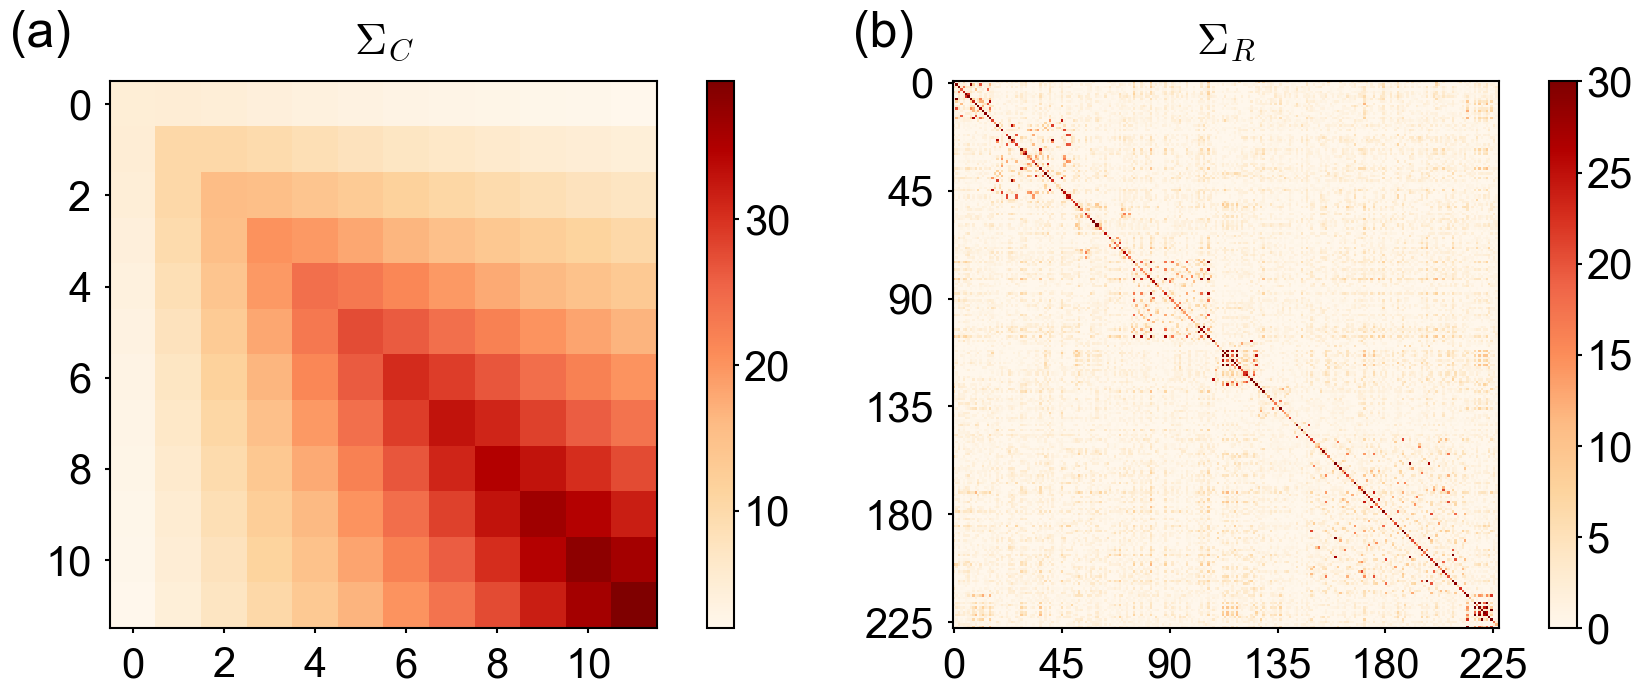

In [ ]:
nrow = 1
ncol = 2

labels = ["(a)", "(b)", "(c)", "(d)"]
fig = plt.figure(figsize=(22, 15))
trans = mtransforms.ScaledTranslation(-1, 17/72, fig.dpi_scale_trans)

gs = gridspec.GridSpec(nrow, ncol,
         wspace=0.35, hspace=0.45,
         top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1),
         left=0.5/(ncol+1), right=1-0.5/(ncol+1))

ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])

# color = 'Reds'
color = 'OrRd'

norm1 = None
# norm1 = Normalize(vmin=0)
im1 = ax1.imshow(row_cov.cpu().detach().numpy(), interpolation='none', cmap=color, norm=norm1)
ax1.set(xticks=np.arange(0, args.out_dim, 2), xticklabels=np.arange(0, args.out_dim, 2), yticks=np.arange(0, args.out_dim, 2), yticklabels=np.arange(0, args.out_dim, 2), rasterized=True)
ax1.set_title(r'$\mathbf{\Sigma}_C$', pad=20)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.5)
fig.colorbar(im1, cax=cax, orientation='vertical')
ax1.text(0.0, 1.0, labels[0], transform=ax1.transAxes+trans, fontsize=36, va='bottom')

# norm2 = None
norm2 = Normalize(vmin=0, vmax=30, clip=True)
im2 = ax2.imshow(col_cov.cpu().detach().numpy(), interpolation='none', cmap=color, norm=norm2)
ax2.set(xticks=np.arange(0, num_nodes, int(num_nodes/5)), yticks=np.arange(0, num_nodes, int(num_nodes/5)), rasterized=True)
ax2.set_title(r'$\mathbf{\Sigma}_R$', pad=20)

ax1.tick_params(axis='x', pad=10)
ax1.tick_params(axis='y', pad=10)
ax2.tick_params(axis='x', pad=10)
ax2.tick_params(axis='y', pad=10)

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.5)
fig.colorbar(im2, cax=cax, orientation='vertical')
ax2.text(0.0, 1.0, labels[1], transform=ax2.transAxes+trans, fontsize=36, va='bottom')

fig.savefig("figs/gwave_pm7m_empirical_cov.pdf", bbox_inches='tight', dpi=300)

# Correlation Matrix

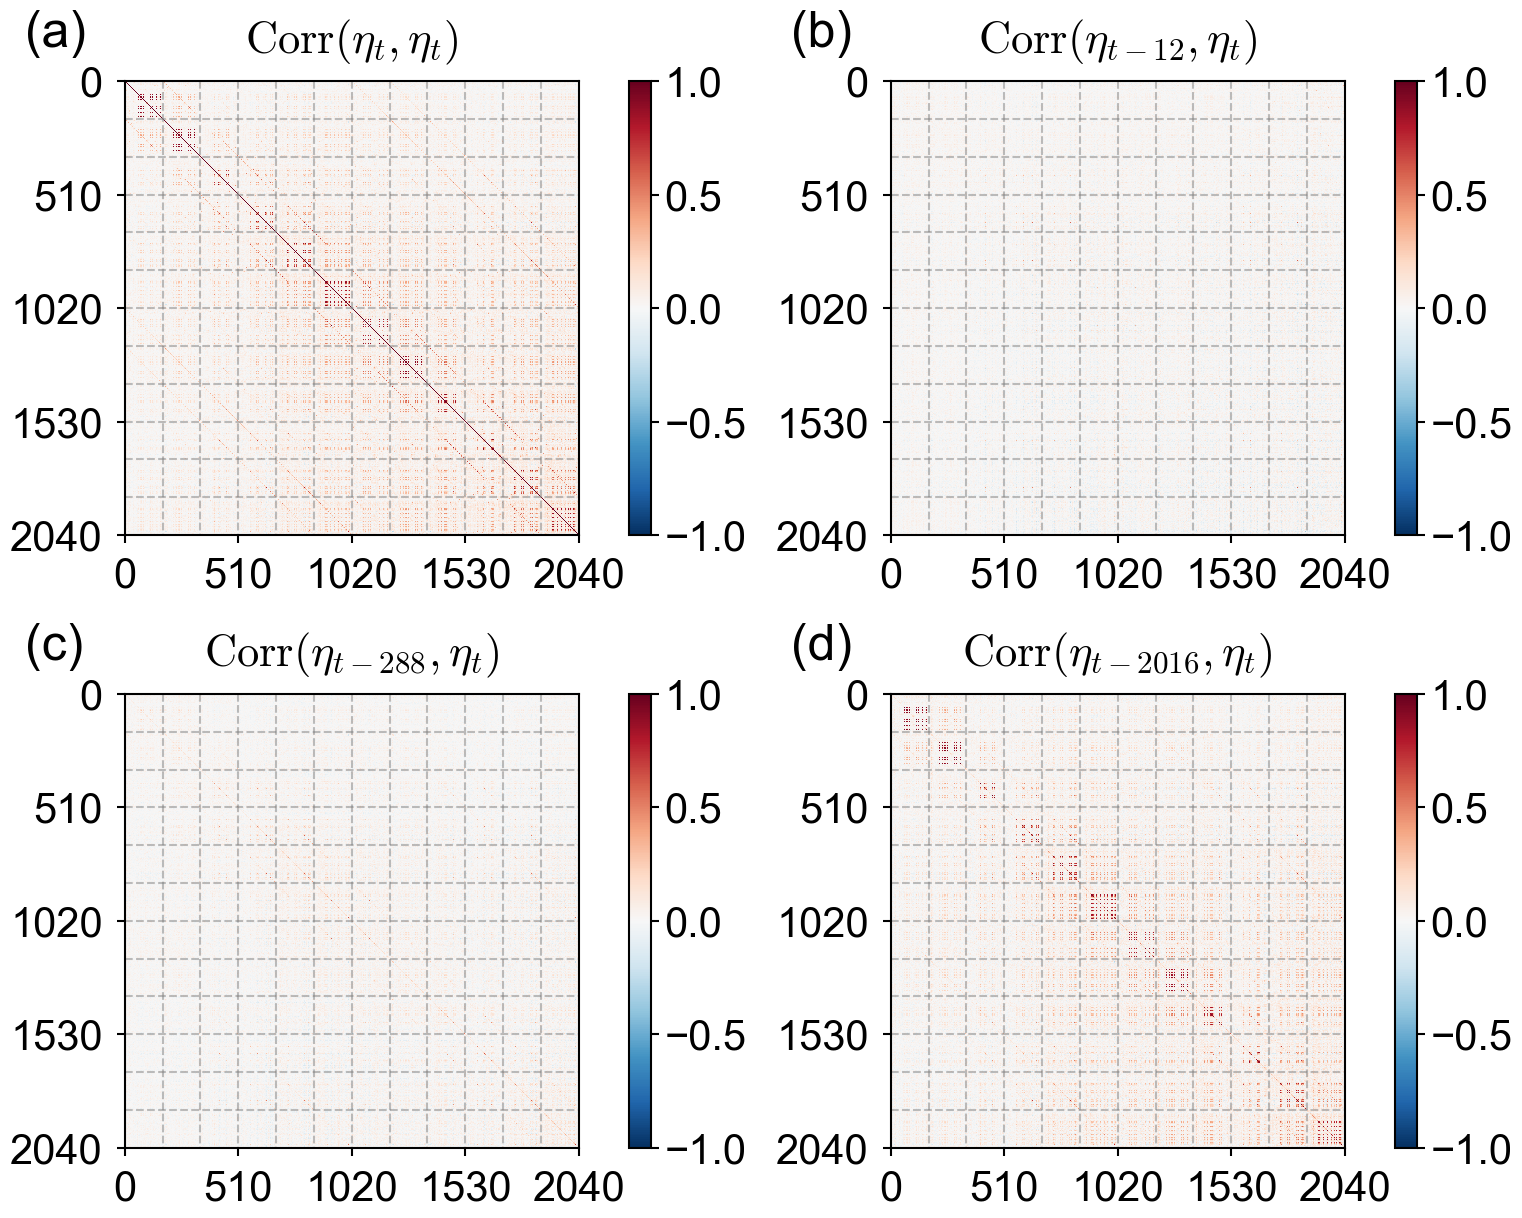

In [ ]:
font_addup=12
params = {'figure.titlesize':20+font_addup,
         'legend.fontsize':18+font_addup,
         'axes.labelsize':20+font_addup,
         'axes.titlesize':20+font_addup,
         'axes.linewidth':1.5,
         'xtick.labelsize':18+font_addup,
         'ytick.labelsize':18+font_addup,
         'xtick.major.width':1.5,
         'ytick.major.width':1.5,
         'xtick.major.size':6,
         'ytick.major.size':6,
         'font.family':'sans-serif',
         'font.sans-serif':'Arial',
         'mathtext.fontset':'cm',
         'pdf.fonttype':42,
         'xtick.direction':'out',
         'ytick.direction':'out'}
pylab.rcParams.update(params)


nrow = 2
ncol = 2

labels = ["(a)", "(b)", "(c)", "(d)"]
shifts = [0, 12, num_stp_perday, num_stp_perday*7]
fig = plt.figure(figsize=(20, 16))

gs = gridspec.GridSpec(nrow, ncol,
         wspace=0.35, hspace=0.35,
         top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1),
         left=0.5/(ncol+1), right=1-0.5/(ncol+1))


pic_id = 0
for i in range(nrow):
    for j in range(ncol):
        ax = plt.subplot(gs[i,j])

        trans = mtransforms.ScaledTranslation(-1, 17/72, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, labels[pic_id], transform=ax.transAxes+trans, fontsize=36, va='bottom')

        shift = shifts[pic_id]
        res_x = torch.roll(y_test_res, shifts=shift, dims=0)[shift:]
        res_y = y_test_res[shift:]
        res_xy = torch.cat([res_x.flatten(start_dim=1), res_y.flatten(start_dim=1)], dim=-1).T
        corr = torch.corrcoef(res_xy)

        norm = Normalize(vmin=-1, vmax=1)
        im = ax.imshow(corr.cpu()[num_nodes*args.f_step:,:num_nodes*args.f_step], interpolation='none', cmap='RdBu_r', norm=norm)
        ax.hlines(y=np.arange(num_nodes, num_nodes*args.f_step, num_nodes), xmin=0, xmax=num_nodes*args.f_step, colors='grey', linestyles='dashed', alpha=0.5)
        ax.vlines(x=np.arange(num_nodes, num_nodes*args.f_step, num_nodes), ymin=0, ymax=num_nodes*args.f_step, colors='grey', linestyles='dashed', alpha=0.5)

        if pic_id ==0:
            ax.set_title(r'$\operatorname{Corr}(\eta_{t}, \eta_{t})$', pad=20)
        else:
            ax.set_title(r'$\operatorname{Corr}(\eta_{t-%s}, \eta_{t})$'%(shift), pad=20)

        ax.set(xticks=np.arange(0, num_nodes*(args.f_step+1), num_nodes*3), yticks=np.arange(0, num_nodes*(args.f_step+1), num_nodes*3), xlim=(0, num_nodes*args.f_step), ylim=(num_nodes*args.f_step, 0), rasterized=True)
        ax.tick_params(axis='x', pad=10)
        ax.tick_params(axis='y', pad=10)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.5)
        cbar = plt.colorbar(im, cax=cax, orientation='vertical')
        pic_id += 1

fig.savefig("figs/fig2_gwave_pm08_res.pdf", bbox_inches='tight', dpi=300)

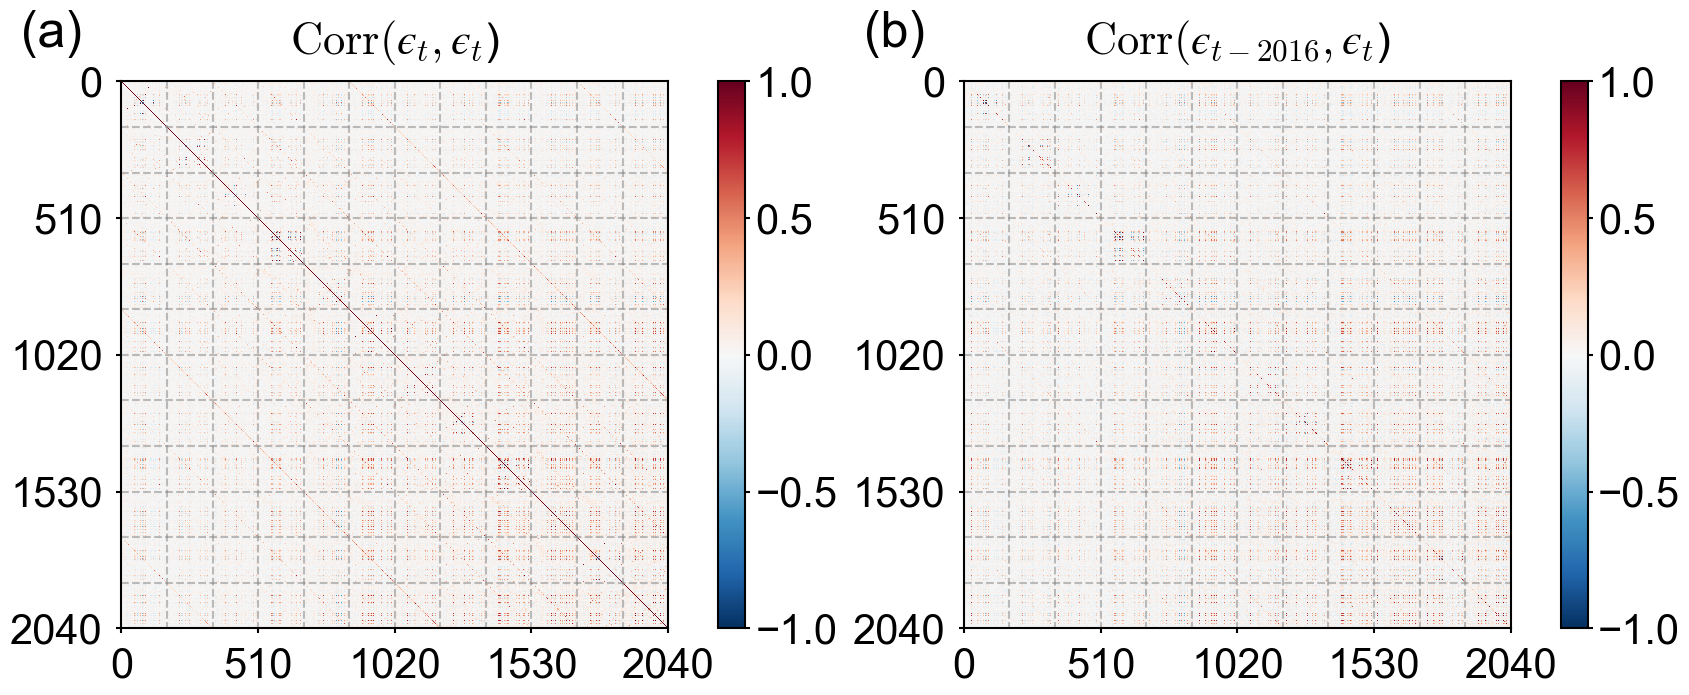

In [ ]:
nrow = 1
ncol = 2

labels = ["(a)", "(b)", "(c)", "(d)"]
shifts = [0, num_stp_perday*7]
fig = plt.figure(figsize=(22, 15))

gs = gridspec.GridSpec(nrow, ncol,
         wspace=0.35, hspace=0.45,
         top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1),
         left=0.5/(ncol+1), right=1-0.5/(ncol+1))


pic_id = 0
for i in range(nrow):
    for j in range(ncol):
        ax = plt.subplot(gs[i,j])

        trans = mtransforms.ScaledTranslation(-1, 17/72, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, labels[pic_id], transform=ax.transAxes+trans, fontsize=36, va='bottom')

        shift = shifts[pic_id]
        res_x = torch.roll(y_test_res, shifts=shift, dims=0)[shift:]
        res_y = y_test_res[shift:]
        res_xy = torch.cat([res_x.flatten(start_dim=1), res_y.flatten(start_dim=1)], dim=-1).T
        corr = torch.corrcoef(res_xy)

        # norm = CenteredNorm(vcenter=0)
        norm = Normalize(vmin=-1, vmax=1)
        im = ax.imshow(corr.cpu()[num_nodes*12:,:num_nodes*12], interpolation='none', cmap='RdBu_r', norm=norm)

        ax.hlines(y=np.arange(num_nodes, num_nodes*12, num_nodes), xmin=0, xmax=num_nodes*12, colors='grey', linestyles='dashed', alpha=0.5)
        ax.vlines(x=np.arange(num_nodes, num_nodes*12, num_nodes), ymin=0, ymax=num_nodes*12, colors='grey', linestyles='dashed', alpha=0.5)

        if pic_id ==0:
            ax.set_title(r'$\operatorname{Corr}(ϵ_{t}, ϵ_{t}$)', pad=20)
        else:
            ax.set_title(r'$\operatorname{Corr}(ϵ_{t-%s}, ϵ_{t}$)'%(shift), pad=20)

        ax.set(xticks=np.arange(0, num_nodes*13, num_nodes*3), yticks=np.arange(0, num_nodes*13, num_nodes*3), xlim=(0, num_nodes*12), ylim=(num_nodes*12, 0), rasterized=True)
        ax.tick_params(axis='x', pad=10)
        ax.tick_params(axis='y', pad=10)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.5)
        fig.colorbar(im, cax=cax, orientation='vertical')
        pic_id += 1

fig.savefig("figs/fig3_gwave_dr_pm08_res.pdf", bbox_inches='tight', dpi=300)

# Covariance Matrix

In [24]:
L_q = model.cov_model.L_q / model.cov_model._cov_factor_scale_q
L_n = model.cov_model.L_n / model.cov_model._cov_factor_scale_n

cov_spatial = L_n@L_n.T
cov_temporal = L_q@L_q.T

Text(0.0, 1.0, '(b)')

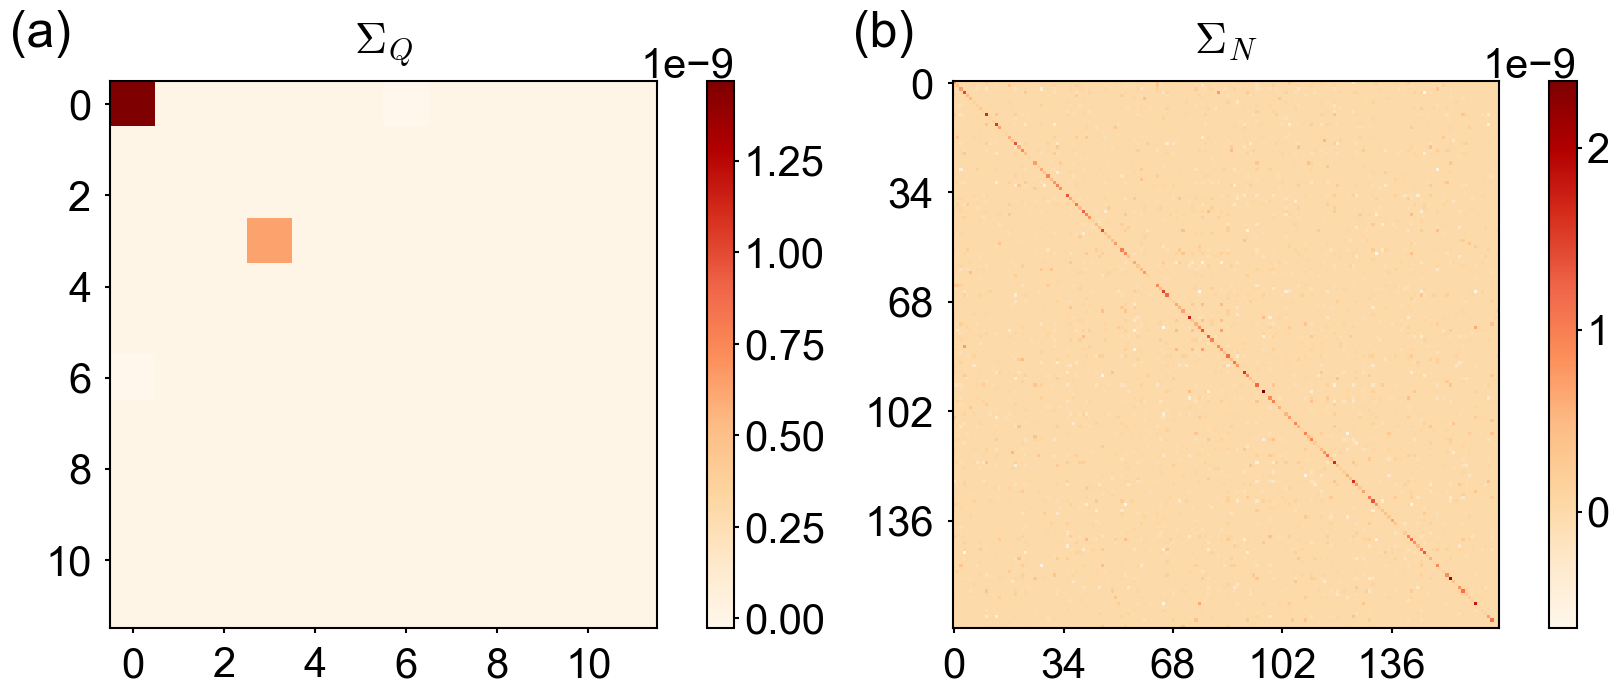

In [26]:
nrow = 1
ncol = 2

labels = ["(a)", "(b)", "(c)", "(d)"]
fig = plt.figure(figsize=(22, 15))
trans = mtransforms.ScaledTranslation(-1, 17/72, fig.dpi_scale_trans)

gs = gridspec.GridSpec(nrow, ncol,
         wspace=0.35, hspace=0.45,
         top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1),
         left=0.5/(ncol+1), right=1-0.5/(ncol+1))

ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])

# color = 'Reds'
color = 'OrRd'

norm1 = None
# norm1 = Normalize(vmin=0)
im1 = ax1.imshow(cov_temporal.cpu().detach().numpy(), interpolation='none', cmap=color, norm=norm1)
ax1.set(xticks=np.arange(0, args.out_dim, 2), xticklabels=np.arange(0, args.out_dim, 2), yticks=np.arange(0, args.out_dim, 2), yticklabels=np.arange(0, args.out_dim, 2), rasterized=True)
ax1.set_title(r'$\mathbf{\Sigma}_Q$', pad=20)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.5)
fig.colorbar(im1, cax=cax, orientation='vertical')
ax1.text(0.0, 1.0, labels[0], transform=ax1.transAxes+trans, fontsize=36, va='bottom')

norm2 = None
# norm2 = Normalize(vmin=0, vmax=0.01, clip=True)
im2 = ax2.imshow(cov_spatial.cpu().detach().numpy(), interpolation='none', cmap=color, norm=norm2)
ax2.set(xticks=np.arange(0, num_nodes, int(num_nodes/5)), yticks=np.arange(0, num_nodes, int(num_nodes/5)), rasterized=True)
ax2.set_title(r'$\mathbf{\Sigma}_N$', pad=20)

ax1.tick_params(axis='x', pad=10)
ax1.tick_params(axis='y', pad=10)
ax2.tick_params(axis='x', pad=10)
ax2.tick_params(axis='y', pad=10)

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.5)
fig.colorbar(im2, cax=cax, orientation='vertical')
ax2.text(0.0, 1.0, labels[1], transform=ax2.transAxes+trans, fontsize=36, va='bottom')

# fig.savefig("figs/fig5_gwave_pm7m_cov.pdf", bbox_inches='tight', dpi=300)

In [14]:
adj_mx = np.load(os.path.join(args.adj_path, 'adj_mx_%s.npy'%(args.data)))

# DR Matrix

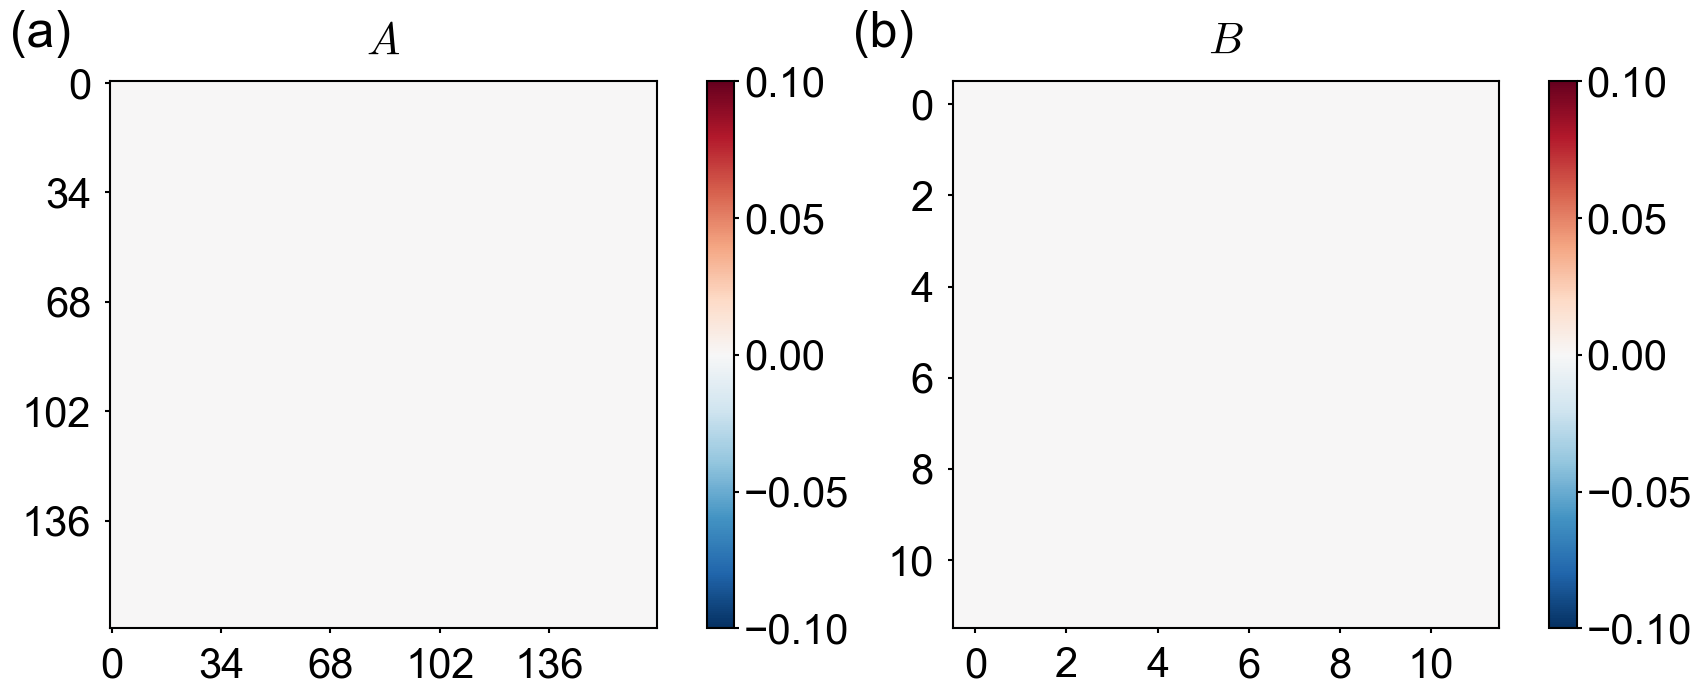

In [27]:
nrow = 1
ncol = 2

labels = ["(a)", "(b)", "(c)", "(d)"]
fig = plt.figure(figsize=(22, 15))
trans = mtransforms.ScaledTranslation(-1, 17/72, fig.dpi_scale_trans)

gs = gridspec.GridSpec(nrow, ncol,
         wspace=0.35, hspace=0.45,
         top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1),
         left=0.5/(ncol+1), right=1-0.5/(ncol+1))

ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])

# norm1 = Normalize(vmin=0, vmax=0.2, clip=True)
# norm2 = Normalize(vmin=0, vmax=0.2, clip=True)
# im1 = ax1.imshow(model.res_model.B.abs().cpu().detach().numpy(), interpolation='none', cmap='gist_heat_r', norm=norm1)
# im2 = ax2.imshow(model.res_model.A.abs().cpu().detach().numpy(), interpolation='none', cmap='gist_heat_r', norm=norm2)

norm1 = None
norm2 = None
# norm1 = CenteredNorm(vcenter=0)
# norm2 = CenteredNorm(vcenter=0)
# norm1 = Normalize(vmin=-0.5, vmax=0.5, clip=True)
# norm2 = Normalize(vmin=-0.5, vmax=0.5, clip=True)
im1 = ax1.imshow(model.res_model.B.cpu().detach().numpy(), interpolation='none', cmap='RdBu_r', norm=norm1)
im2 = ax2.imshow(model.res_model.A.cpu().detach().numpy(), interpolation='none', cmap='RdBu_r', norm=norm2)

ax2.set(xticks=np.arange(0, args.out_dim, 2), xticklabels=np.arange(0, args.out_dim, 2), yticks=np.arange(0, args.out_dim, 2), yticklabels=np.arange(0, args.out_dim, 2), rasterized=True)
ax1.set(xticks=np.arange(0, num_nodes, int(num_nodes/5)), yticks=np.arange(0, num_nodes, int(num_nodes/5)), rasterized=True)

ax1.tick_params(axis='x', pad=10)
ax1.tick_params(axis='y', pad=10)
ax2.tick_params(axis='x', pad=10)
ax2.tick_params(axis='y', pad=10)

ax2.set_title(r'$B$', pad=20)
ax1.set_title(r'$A$', pad=20)

ax1.text(0.0, 1.0, labels[0], transform=ax1.transAxes+trans, fontsize=36, va='bottom')
ax2.text(0.0, 1.0, labels[1], transform=ax2.transAxes+trans, fontsize=36, va='bottom')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.5)
fig.colorbar(im1, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.5)
fig.colorbar(im2, cax=cax, orientation='vertical')

# fig.savefig("figs/fig4_gwave_pm08_ar_coef.pdf", bbox_inches='tight', dpi=300)

# Probabilistic Forecasting

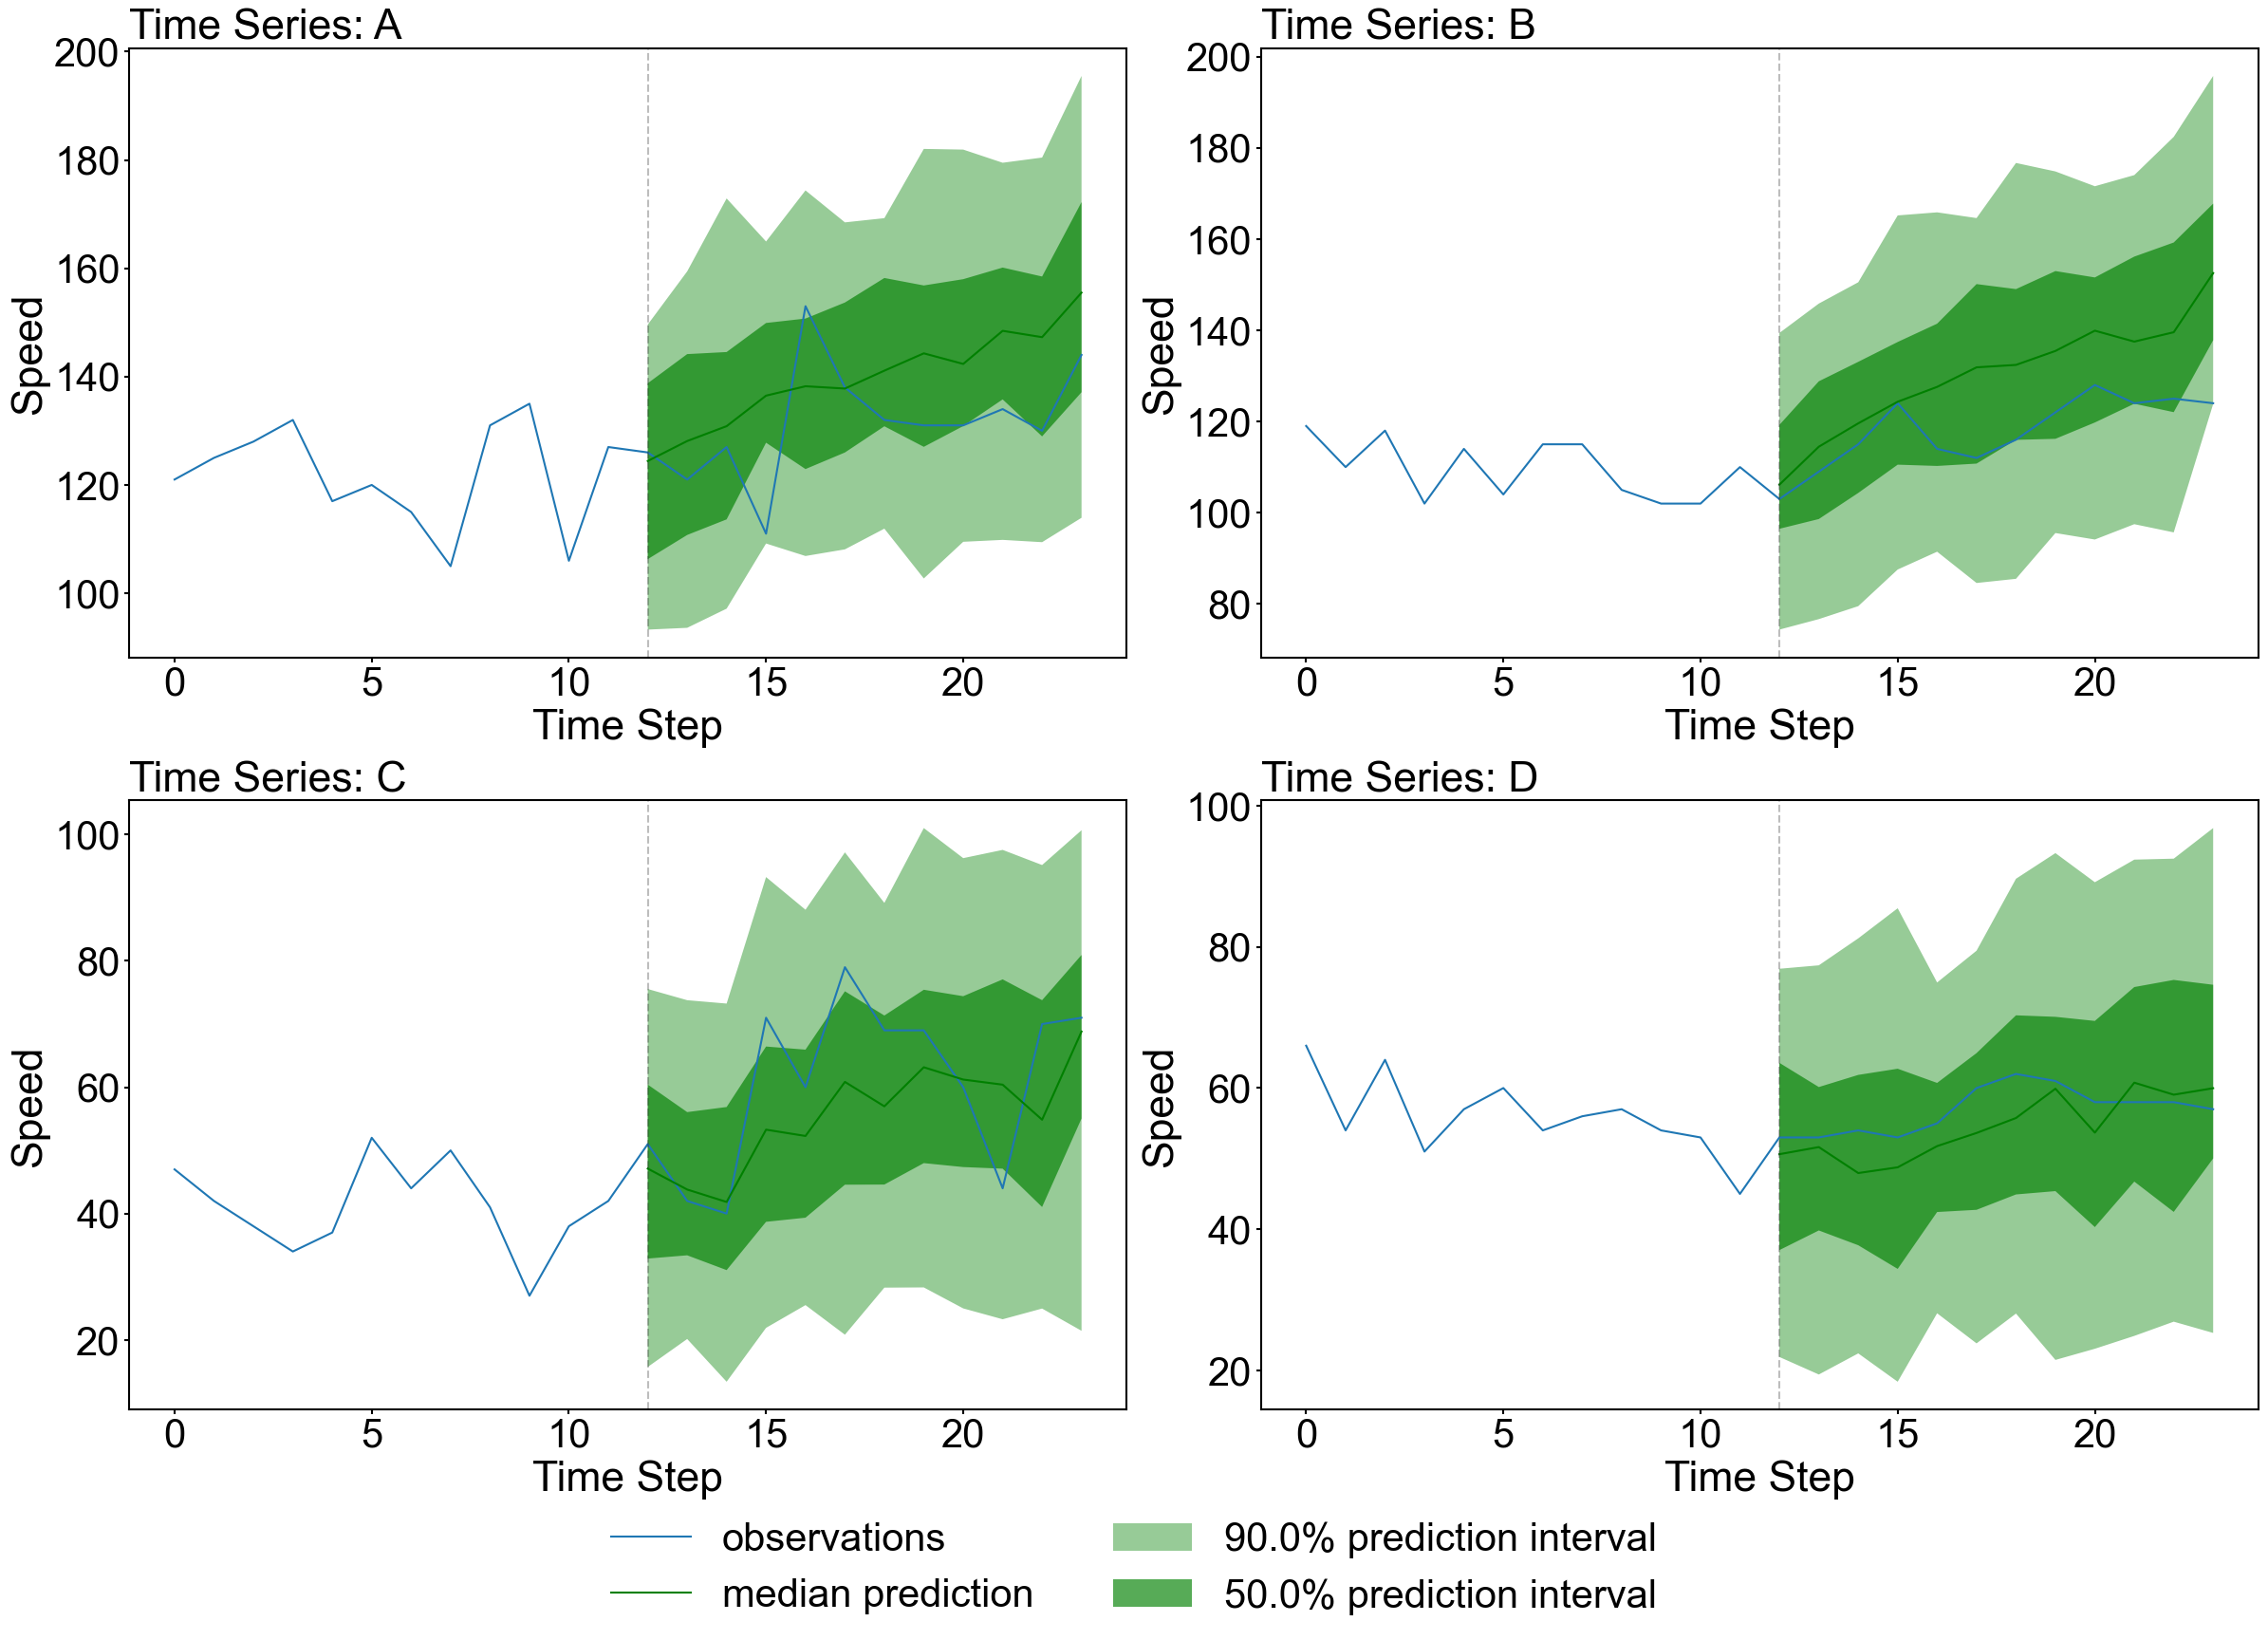

In [ ]:
nrow = 2
ncol = 2

prediction_intervals = (50.0, 90.0)

fig, axs = plt.subplots(nrow, ncol, figsize=(24, 16))
axx = axs.ravel()

ps = [50.0] + [
        50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
    ]

percentiles_sorted = sorted(set(ps))

def alpha_for_percentile(p):
    return (p / 100.0) ** 0.3

sensors = ['A', 'B', 'C', 'D']
# pemsd7m
# senor_loc = [1, 7, 8, 15]
# t_start = 160
# pems08
senor_loc = [160, 161, 163, 164]
t_start = 160

for i in range(nrow*ncol):
    ax = axx[i]

    true_series = pd.Series(torch.cat([x_test[t_start, :, senor_loc[i]], y_test_true[t_start, :, senor_loc[i]]]).cpu(), index=np.arange(x_test.shape[1]+y_test_true.shape[1]))

    ax.plot(true_series, label=r"observations")

    ps_data = [y_test_hat.quantile(q=p/100.0, dim=1)[t_start, :, senor_loc[i]].cpu() for p in percentiles_sorted]
    i_p50 = len(percentiles_sorted)//2

    p50_data = ps_data[i_p50]
    p50_series = pd.Series(data=p50_data, index=np.arange(x_test.shape[1], x_test.shape[1]+y_test_true.shape[1]))
    ax.plot(p50_series, color='g', ls="-", label=r"median prediction")

    ax.axvline(12, linewidth=1.5, linestyle='dashed', color='#252525', alpha=.3)
    ax.set_xlabel(r'Time Step')
    ax.set_ylabel(r'Speed')
    ax.set_title(r'Time Series: %s'%(sensors[i]), loc="left")

    for i in range(len(percentiles_sorted)//2):
        ptile = percentiles_sorted[i]
        alpha = alpha_for_percentile(ptile)
        ax.fill_between(
            np.arange(x_test.shape[1], x_test.shape[1]+y_test_true.shape[1]),
            ps_data[i],
            ps_data[-i - 1],
            facecolor='g',
            alpha=alpha,
            interpolate=True,
            label=f"{100 - ptile * 2}% prediction interval",
        )


handles, labels = axx[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.09), frameon=False)
fig.tight_layout()

# fig.savefig("figs/fig6_gwave_pm7m_prob.pdf", bbox_inches='tight', dpi=300)
# fig.savefig("figs/fig7_gwave_pm7m_prob_dr.pdf", bbox_inches='tight', dpi=300)
# fig.savefig("figs/fig8_gwave_pm08_prob.pdf", bbox_inches='tight', dpi=300)
fig.savefig("figs/fig9_gwave_pm08_prob_dr.pdf", bbox_inches='tight', dpi=300)

# Ablations

## AR order

In [6]:
loss_type = ("isotropic", "non-isotropic")
# rrmse = {
#     r'$p=1, \Delta=2016$': (0.1628, 0.1639),
#     r'$p=2, \Delta=288,2016$': (0.1643, 0.1632),
#     r'$p=3, \Delta=12,288,2016$': (0.1746, 0.1649),
# }
rrmse = {
    'p=1': (0.1628, 0.1639),
    'p=2': (0.1643, 0.1632),
    'p=3': (0.1746, 0.1649),
}
crps_sum = {
    'p=1': (0.0524, 0.0465),
    'p=2': (0.0528, 0.0461),
    'p=3': (0.0573, 0.0469),
}
p50 = {
    'p=1': (0.065, 0.0619),
    'p=2': (0.0657, 0.0615),
    'p=3': (0.0714, 0.0626),
}
p75 = {
    'p=1': (0.0606, 0.0517),
    'p=2': (0.061, 0.0512),
    'p=3': (0.0666, 0.0525),
}
p90 = {
    'p=1': (0.0384, 0.0321),
    'p=2': (0.0386, 0.0318),
    'p=3': (0.0422, 0.0327),
}

# data_dict = {"$\operatorname{RRMSE}$": rrmse, "$\operatorname{CRPS}_{\mathrm{sum}}$": crps_sum, "$0.5$-risk": p50, "$0.75$-risk": p75, "$0.9$-risk": p90}

data_dict = {"$\operatorname{RRMSE}$": rrmse, "$\operatorname{CRPS}$": crps_sum, "$0.5$-risk": p50, "$0.75$-risk": p75, "$0.9$-risk": p90}

In [7]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

categories = ['p=1', 'p=2', 'p=3']
cmap = cm.viridis_r
norm = [0.15, 0.35, 0.55]
category_colors = {category: cmap(norm[i]) for i, category in enumerate(categories)}
# Get the colors for each bar based on category
colors = [category_colors[category] for category in categories]

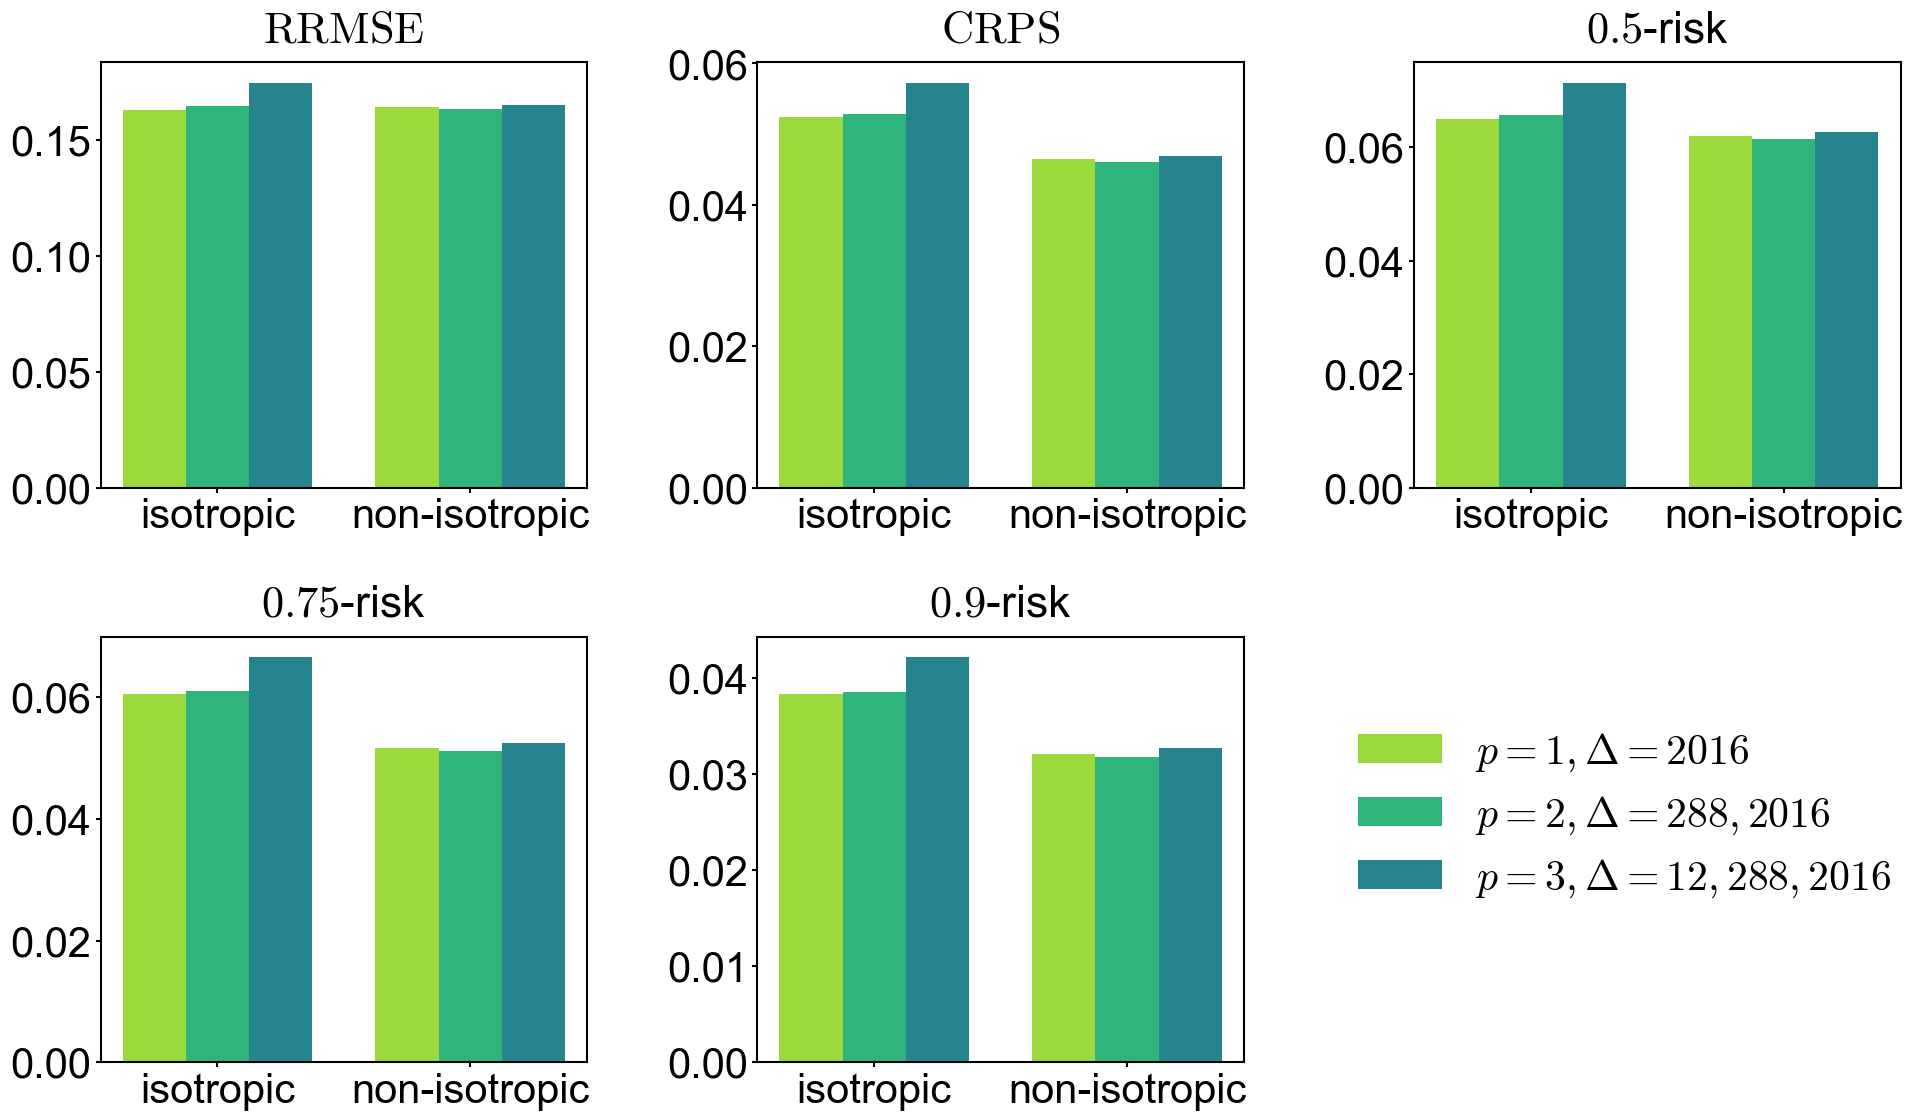

In [ ]:
nrow = 2
ncol = 3

# Create a figure
fig = plt.figure(figsize=(24, 15))
trans = mtransforms.ScaledTranslation(-1, 17/72, fig.dpi_scale_trans)

# Create a GridSpec with 2 rows and 3 columns
gs = gridspec.GridSpec(nrow, ncol,
         wspace=0.35, hspace=0.35,
         top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1),
         left=0.5/(ncol+1), right=1-0.5/(ncol+1))

ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[0,2])
ax4 = plt.subplot(gs[1,0])
ax5 = plt.subplot(gs[1,1])
axx = [ax1, ax2, ax3, ax4, ax5]

# fig, axs = plt.subplots(nrow, ncol, figsize=(32, 12))
# axx = axs.ravel()

key_list = list(data_dict.keys())
for i in range(nrow*ncol):
    if i < len(key_list):
        ax = axx[i]

        x = np.arange(len(loss_type))  # the label locations
        width = 0.25  # the width of the bars
        multiplier = 0

        for attribute, measurement in data_dict[key_list[i]].items():
            offset = width * multiplier
            rects = ax.bar(x + offset, measurement, width, label=attribute, color=category_colors[attribute])
            # ax.bar_label(rects, padding=3, fontsize=18)
            multiplier += 1

        ax.set_xticks(x + width, loss_type)
        # ax.set_ylabel(r"%s"%(key_list[i]))
        ax.set_title(r"%s"%(key_list[i]), pad=15)


handles, labels = axx[0].get_legend_handles_labels()

labels = [
    '$p=1, \Delta=2016$',
    '$p=2, \Delta=288,2016$',
    '$p=3, \Delta=12,288,2016$'
]

fig.legend(handles, labels, loc='lower center', ncol=1, bbox_to_anchor=(0.76, 0.25), frameon=False)
fig.savefig("figs/ar_order_new.pdf", bbox_inches='tight', dpi=300)

# Test for Normality

In [60]:
import pingouin as pg
from scipy.stats import shapiro

In [63]:
eps = y_test_res.flatten(start_dim=1)
eps = scaler.transform(eps)
print(eps.shape)

torch.Size([2530, 2736])


In [54]:
mardia_test = pg.multivariate_normality(eps.cpu().numpy()[:2016, :], alpha=0.05)
print(mardia_test)

HZResults(hz=8064, pval=nan, normal=False)


In [8]:
data = np.random.multivariate_normal(mean=[0, 0], cov=[[1, 0.5], [0.5, 1]], size=100)
df = pd.DataFrame(data, columns=['x', 'y'])
df.shape

(100, 2)

In [11]:
mardia_test = pg.multivariate_normality(df, alpha=0.05)
print(mardia_test)

HZResults(hz=0.5688051408097805, pval=0.4505333916082362, normal=True)


In [56]:
mean = np.zeros((3, 4))  # Mean matrix
row_cov = np.eye(3)      # Row covariance matrix (3x3)
col_cov = np.eye(4)      # Column covariance matrix (4x4)

# Generate matrix normal distributed data
data = np.random.multivariate_normal(mean.ravel(), np.kron(col_cov, row_cov), size=1)
data = data.reshape(mean.shape)

In [57]:
data.shape

(3, 4)

In [59]:
vectorized_data = data.ravel()
vectorized_data.shape

(12,)

In [61]:
shapiro_test = shapiro(vectorized_data)

In [62]:
print(f"Shapiro-Wilk test: {shapiro_test}")

Shapiro-Wilk test: ShapiroResult(statistic=0.9514398574829102, pvalue=0.6581225395202637)


# CRPS

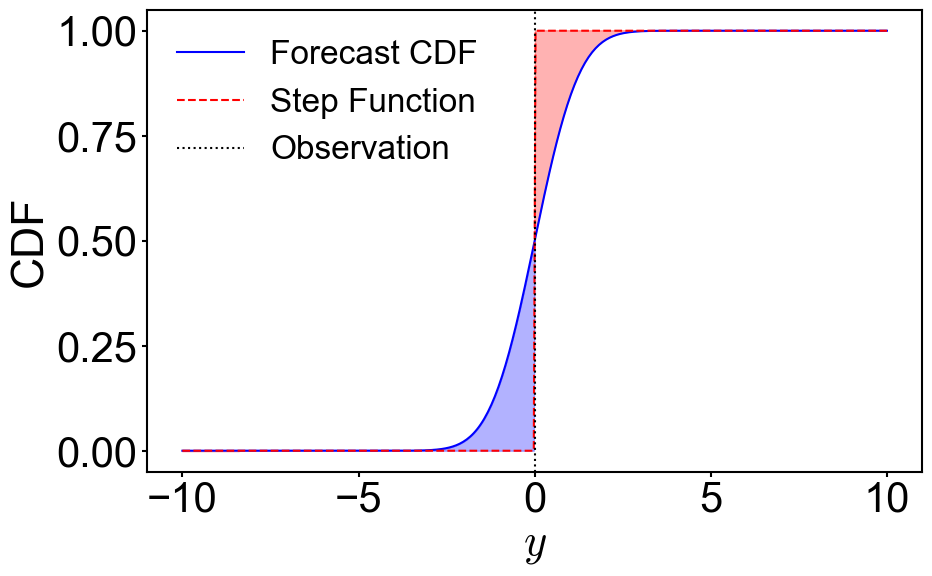

In [111]:
import scipy

# Example data
z_obs = 0.0  # observed value
x = np.linspace(-10, 10, 400)
predicted_cdf = 0.5 * (1 + scipy.special.erf((x - 0) / np.sqrt(2)))  # example CDF (Normal distribution with mean=1 and std=1)

# Step function at observed value
step_function = np.heaviside(x - z_obs, 1)

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the CDF of the predicted distribution
ax.plot(x, predicted_cdf, label='Forecast CDF', color='blue')

# Plot the step function at the observed value
ax.plot(x, step_function, label='Step Function', color='red', linestyle='--')

# Fill the area between the CDF and the step function to represent CRPS
ax.fill_between(x, predicted_cdf, step_function, where=(predicted_cdf > step_function), color='blue', alpha=0.3, interpolate=True)
ax.fill_between(x, predicted_cdf, step_function, where=(predicted_cdf <= step_function), color='red', alpha=0.3, interpolate=True)

# Adding labels and legend
ax.axvline(x=z_obs, color='black', linestyle=':', label='Observation')
# ax.set_title('Illustration of the Continuous Ranked Probability Score (CRPS)')
ax.set_xlabel('$y$')
ax.set_ylabel('CDF')
ax.legend(loc='upper left', frameon=False, fontsize=24)

fig.savefig("figs/crps.pdf", bbox_inches='tight', dpi=300)

# Compare Coavariance 

In [46]:
adj_mx = np.load('../../data/traffic/sensor_graph/npy/adj_mx_%s.npy'%(args.data))

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [45]:
cov_s_full = np.load("data/n_full.npy")
cov_s_120 = np.load("data/n_120.npy")
cov_s_80 = np.load("data/n_80.npy")
cov_s_40 = np.load("data/n_40.npy")
cov_s_10 = np.load("data/n_10.npy")

In [48]:
cov_s_120.shape

(228, 228)

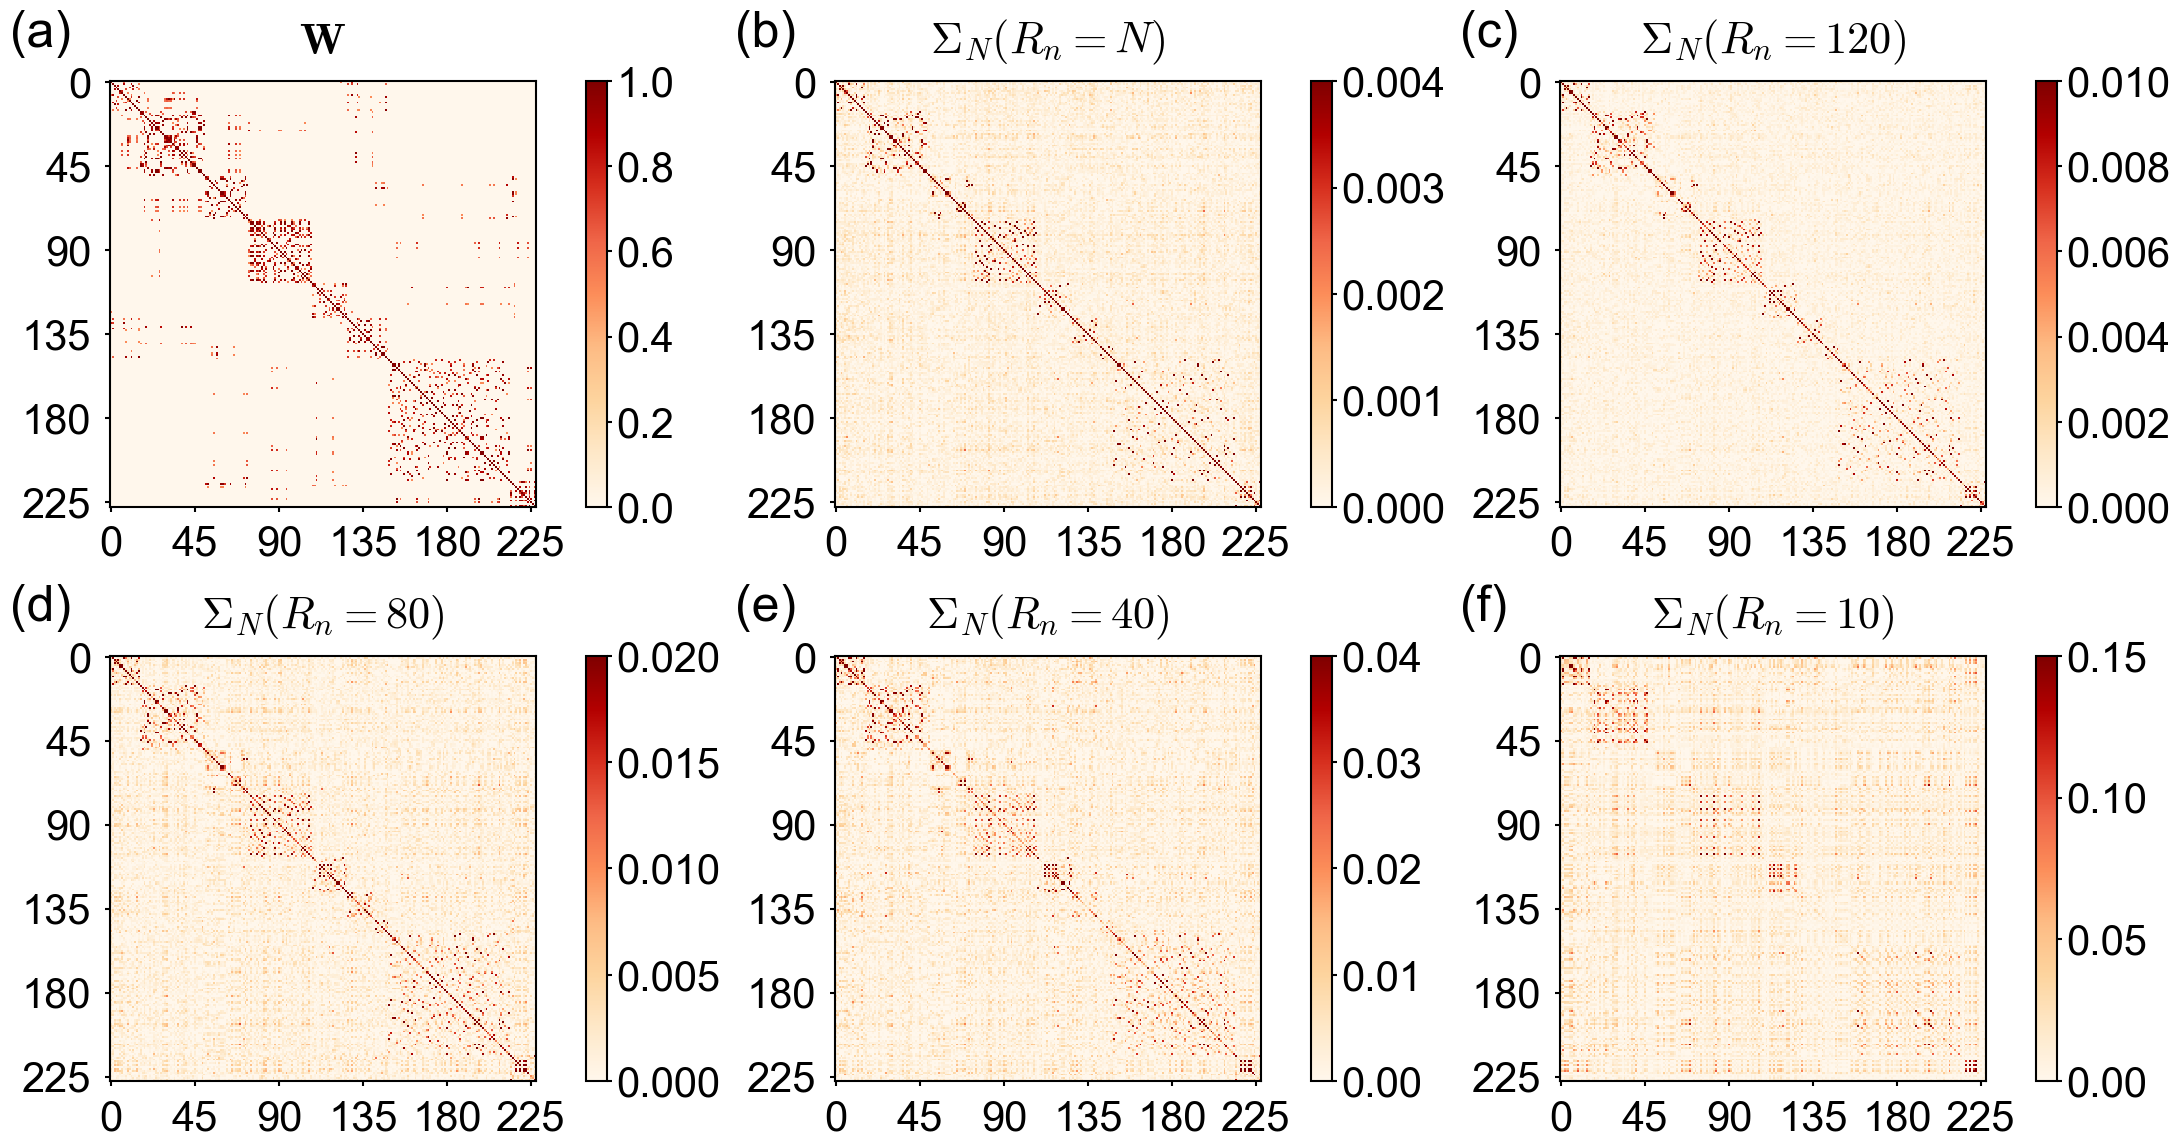

In [ ]:
nrow = 2
ncol = 3

covs = [adj_mx, cov_s_full, cov_s_120, cov_s_80, cov_s_40, cov_s_10]
titles = [r"$\mathbf{W}$", r'$\mathbf{\Sigma}_N (R_n=N)$', r'$\mathbf{\Sigma}_N (R_n=120)$', r'$\mathbf{\Sigma}_N (R_n=80)$', r'$\mathbf{\Sigma}_N (R_n=40)$', r'$\mathbf{\Sigma}_N (R_n=10)$']
norms = [None, Normalize(vmin=0, vmax=0.004, clip=True), Normalize(vmin=0, vmax=0.01, clip=True), Normalize(vmin=0, vmax=0.02, clip=True),
        Normalize(vmin=0, vmax=0.04, clip=True), Normalize(vmin=0, vmax=0.15, clip=True)]


labels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)"]
fig = plt.figure(figsize=(26, 15))
trans = mtransforms.ScaledTranslation(-1, 17/72, fig.dpi_scale_trans)

gs = gridspec.GridSpec(nrow, ncol,
         wspace=0.45, hspace=0.35,
         top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1),
         left=0.5/(ncol+1), right=1-0.5/(ncol+1))


color = 'OrRd'

pos = 0
for i in range(nrow):
    for j in range(ncol):
        ax = plt.subplot(gs[i,j])

        norm = norms[pos]
        im = ax.imshow(covs[pos], interpolation='none', cmap=color, norm=norm)
        ax.set(xticks=np.arange(0, num_nodes, int(num_nodes/5)), yticks=np.arange(0, num_nodes, int(num_nodes/5)), rasterized=True)
        ax.set_title(titles[pos], pad=20)

        ax.tick_params(axis='x', pad=10)
        ax.tick_params(axis='y', pad=10)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.5)
        fig.colorbar(im, cax=cax, orientation='vertical')
        ax.text(0.0, 1.0, labels[pos], transform=ax.transAxes+trans, fontsize=36, va='bottom')

        pos += 1


fig.savefig("figs/compare_rank_cov.pdf", bbox_inches='tight', dpi=300)

# Separate Mean

## Baseline

Text(0.0, 1.0, '(a)')

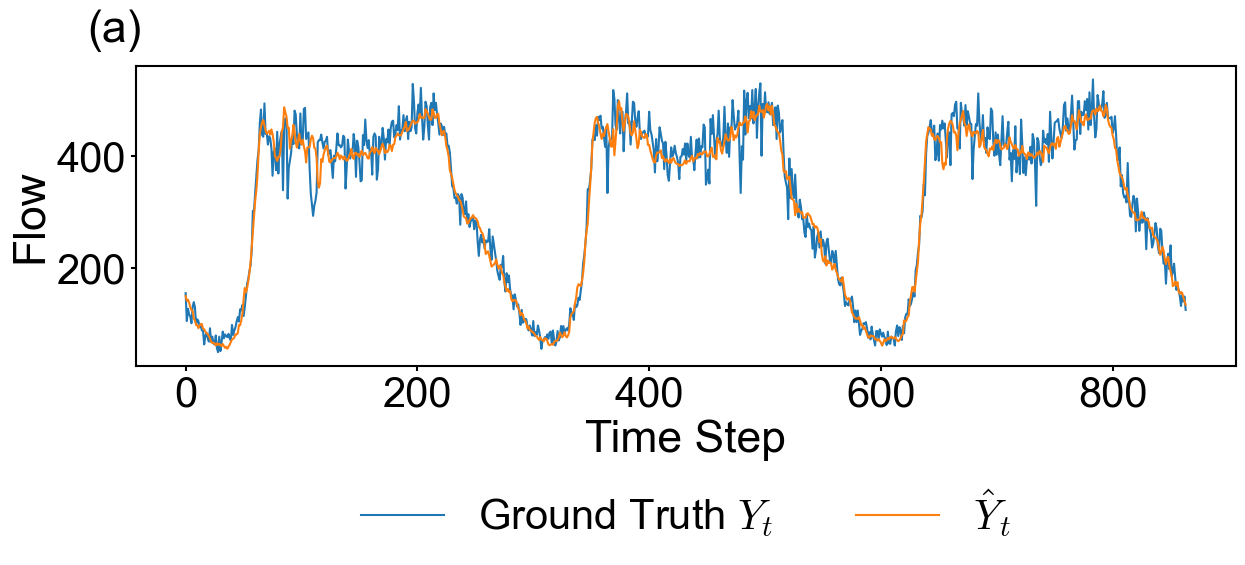

In [ ]:
# lagT-correlation
nrow = 1
ncol = 1

labels = ["(a)", "(b)", "(c)", "(d)"]
shifts = [0, num_stp_perday*7]
fig = plt.figure(figsize=(22, 6))

gs = gridspec.GridSpec(nrow, ncol,
         wspace=0.45, hspace=0.75,
         top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1),
         left=0.5/(ncol+1), right=1-0.5/(ncol+1))


ax1 = plt.subplot(gs[0,0])

ax1.plot(y_test_true[-num_stp_perday*3:,5,0].cpu().detach().numpy(), label=r'Ground Truth $Y_{t}$')
ax1.plot(y_test_hat[-num_stp_perday*3:,5,0].cpu().detach().numpy(), label=r'$\hat{Y}_t$')
ax1.set(xlabel='Time Step', ylabel='Flow')
ax1.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.7), frameon=False)

trans = mtransforms.ScaledTranslation(-35/72, 10/72, fig.dpi_scale_trans)
ax1.text(0.0, 1.0, labels[0], transform=ax1.transAxes+trans, fontsize=32, va='bottom')

# handles, labels = ax1.get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, 0.03), frameon=False)

# fig.savefig("figs/fig6_gwave_pm08_flow.png", bbox_inches='tight', dpi=300)

## DR

In [9]:
debug_mode = args.debug_mode
rank_n_disp = "full" if args.rank_n is None else args.rank_n
rank_q_disp = "full" if args.rank_q is None else args.rank_q

training_data = utils.TrafficDataset(debug_mode, device=device, file_dir=os.path.join(args.data_path, args.data, args.covariates), split='train')
scaler = training_data.__getScaler__()
testing_data = utils.TrafficDataset(debug_mode, device=device, file_dir=os.path.join(args.data_path, args.data, args.covariates), split='test', scaler=scaler)

In [10]:
y_test_base = model.mean_model(testing_data.x[-num_stp_perday*3:,...,:1])
y_test_base = scaler.inverse_transform(y_test_base)
y_test_corec = y_test_hat[-num_stp_perday*3:,...] - y_test_base

In [12]:
print(y_test_true.shape, y_test_base.shape, y_test_hat.shape, y_test_corec.shape)

torch.Size([3567, 12, 170]) torch.Size([864, 12, 170]) torch.Size([3567, 12, 170]) torch.Size([864, 12, 170])


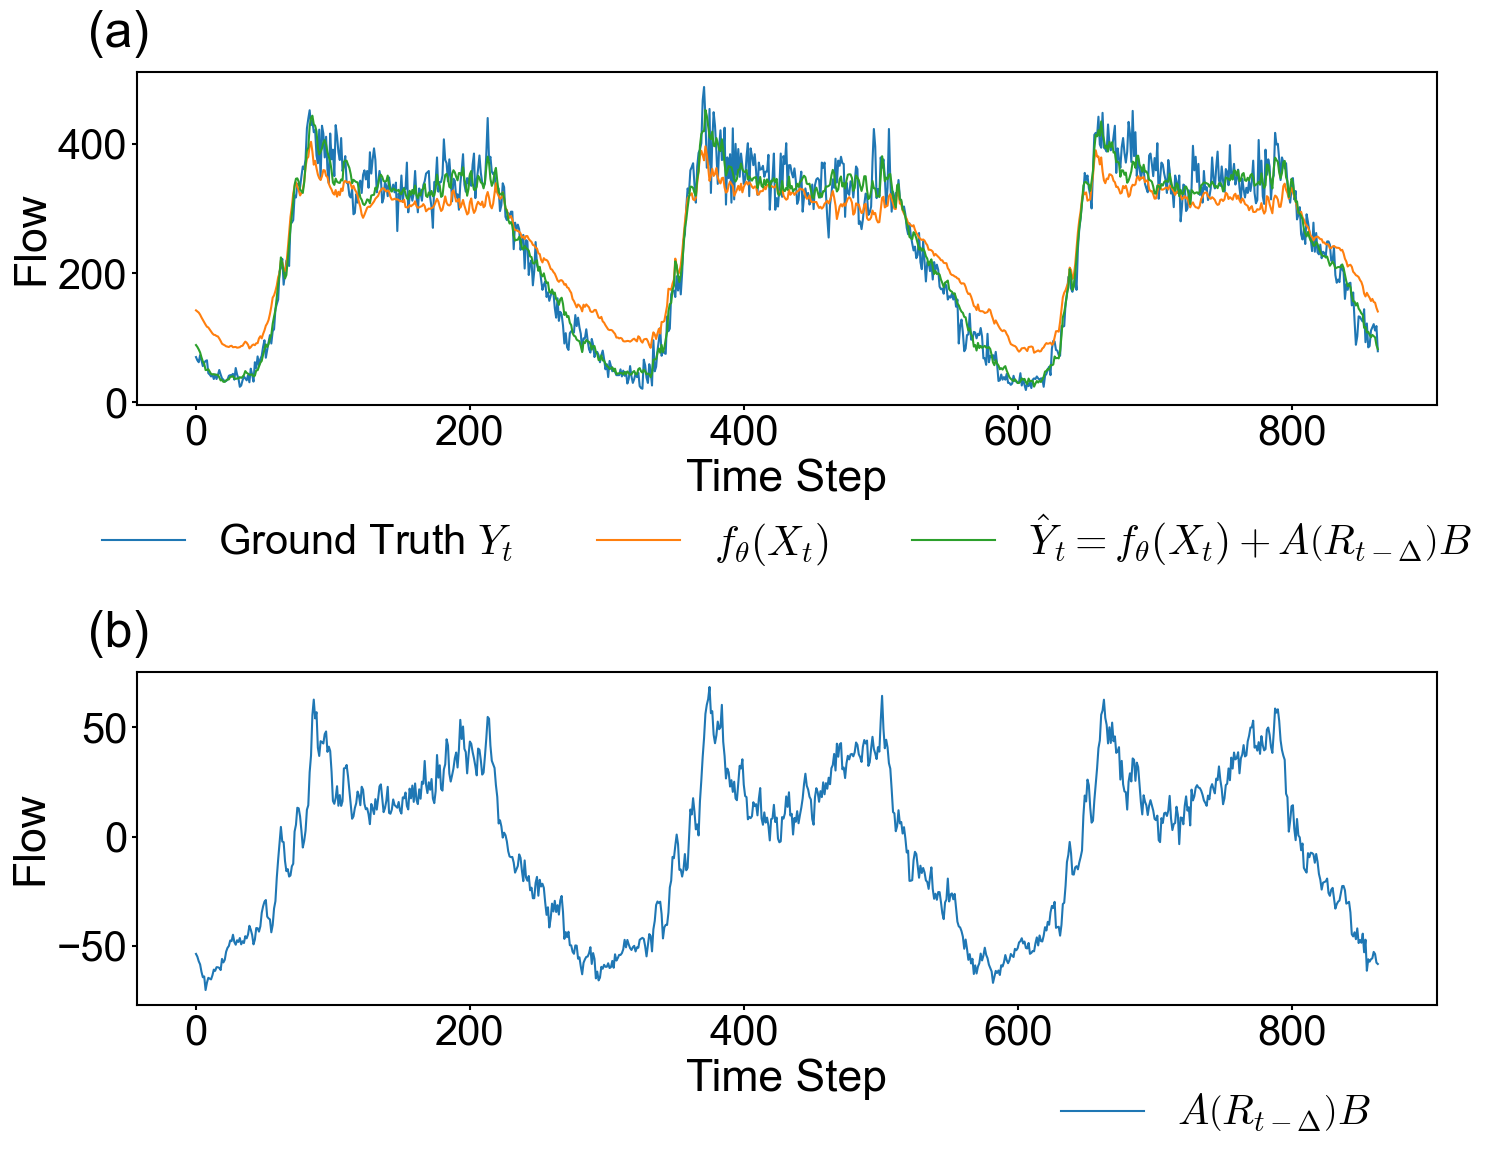

In [ ]:
# lagT-correlation
nrow = 2
ncol = 1

n_step = 5
sensor_id = 5

labels = ["(a)", "(b)", "(c)", "(d)"]
fig = plt.figure(figsize=(26, 14))

gs = gridspec.GridSpec(nrow, ncol,
         wspace=0.45, hspace=0.8,
         top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1),
         left=0.5/(ncol+1), right=1-0.5/(ncol+1))


ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[1,0])

ax1.plot(y_test_true[-num_stp_perday*3:,n_step,sensor_id].cpu().detach().numpy(), label=r'Ground Truth $Y_{t}$')
ax1.plot(y_test_base[:,n_step,sensor_id].cpu().detach().numpy(), label=r'$f_\theta(X_{t})$')
ax1.plot(y_test_hat[-num_stp_perday*3:,n_step,sensor_id].cpu().detach().numpy(), label=r'$\hat{Y}_t = f_\theta(X_{t})+A\left(R_{t-\Delta}\right)B$')
ax1.set(xlabel='Time Step', ylabel='Flow')
ax1.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.6), frameon=False)

# ax1.set_title('1-step ahead', pad=15)

ax2.plot(y_test_corec[:,n_step,sensor_id].cpu().detach().numpy(), label=r'$A\left(R_{t-\Delta}\right)B$')
ax2.set(xlabel='Time Step', ylabel='Flow')
ax2.legend(loc='lower center', ncol=1, bbox_to_anchor=(0.83, -0.5), frameon=False)
# ax2.set_title('6-step ahead', pad=15)

trans = mtransforms.ScaledTranslation(-35/72, 10/72, fig.dpi_scale_trans)
ax1.text(0.0, 1.0, labels[0], transform=ax1.transAxes+trans, fontsize=36, va='bottom')
ax2.text(0.0, 1.0, labels[1], transform=ax2.transAxes+trans, fontsize=36, va='bottom')

# handles, labels = ax1.get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, 0.03), frameon=False)

fig.savefig("figs/gwave_pm08_flow_compare.pdf", bbox_inches='tight', dpi=300)

# Consistency with Traffic Flow

In [6]:
df = pd.read_hdf("../../data/traffic/pems08_flow/pems08_flow.h5")[12:-11]
df.shape

(17833, 170)

In [7]:
flow_np = np.load('../../data/traffic/pems08_flow/flow/test.npz')["y"][...,0]
spd_np = np.load('../../data/traffic/pems08_spd/spd/test.npz')["y"][...,0]
print(flow_np.shape, spd_np.shape)

(3567, 12, 170) (3567, 12, 170)


In [10]:
flow_hat_np = y_test_hat.cpu().numpy()

In [61]:
df_test = df[-flow_np.shape[0]:]
df_test.shape

(3567, 170)

In [62]:
df_test = df_test.reset_index(names=["datetime"])[["datetime"]]
df_test.head()

datetime
0 2016-08-19 13:50:00
1 2016-08-19 13:55:00
2 2016-08-19 14:00:00
3 2016-08-19 14:05:00
4 2016-08-19 14:10:00

In [70]:
from workalendar.usa import UnitedStates

# Initialize the calendar
cal = UnitedStates()

# Define functions to check if a date is a workday or a holiday
def is_workday(date):
    return cal.is_working_day(date)

def is_holiday(date):
    return cal.is_holiday(date)

def is_rushhour(tod):
    if tod in [6,7,8,16,17,18]:
        return True
    else:
        return False

In [63]:
df_test['is_workday'] = df_test['datetime'].apply(is_workday)

In [67]:
df_test['tod'] = df_test["datetime"].dt.hour

datetime  is_workday  tod
0 2016-08-19 13:50:00        True   13
1 2016-08-19 13:55:00        True   13
2 2016-08-19 14:00:00        True   14
3 2016-08-19 14:05:00        True   14
4 2016-08-19 14:10:00        True   14

In [71]:
df_test['is_rushhours'] = df_test['tod'].apply(is_rushhour)

In [74]:
df_test[df_test['is_rushhours'] == True]

datetime  is_workday  tod  is_rushhours
26   2016-08-19 16:00:00        True   16          True
27   2016-08-19 16:05:00        True   16          True
28   2016-08-19 16:10:00        True   16          True
29   2016-08-19 16:15:00        True   16          True
30   2016-08-19 16:20:00        True   16          True
...                  ...         ...  ...           ...
3513 2016-08-31 18:35:00        True   18          True
3514 2016-08-31 18:40:00        True   18          True
3515 2016-08-31 18:45:00        True   18          True
3516 2016-08-31 18:50:00        True   18          True
3517 2016-08-31 18:55:00        True   18          True

[900 rows x 4 columns]

In [83]:
workday_norush_idx = df_test[(df_test['is_workday'] == True) & (df_test['is_rushhours'] == False)].index
workday_rush_idx = df_test[(df_test['is_workday'] == True) & (df_test['is_rushhours'] == True)].index
holiday_idx = df_test[df_test['is_workday'] == False].index
print(workday_norush_idx.shape, workday_rush_idx.shape, holiday_idx.shape)

(1803,) (612,) (1152,)


Text(0.0, 1.0, '(b)')

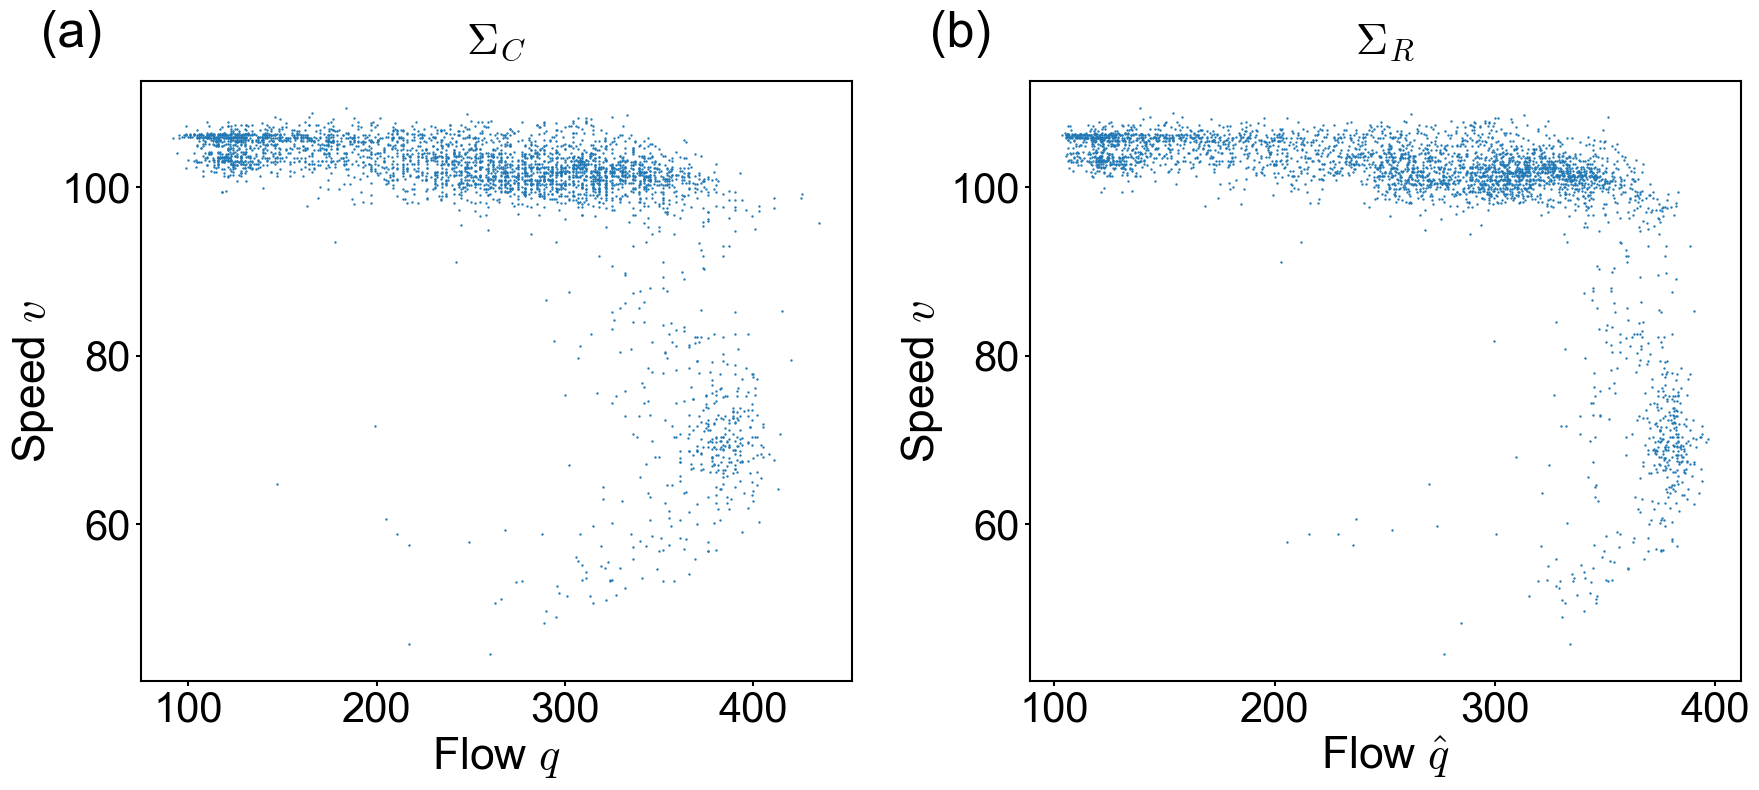

In [ ]:
s_id = 30

nrow = 1
ncol = 2

labels = ["(a)", "(b)", "(c)", "(d)"]
fig = plt.figure(figsize=(24, 12))
trans = mtransforms.ScaledTranslation(-1, 17/72, fig.dpi_scale_trans)

gs = gridspec.GridSpec(nrow, ncol,
         wspace=0.25, hspace=0.45,
         top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1),
         left=0.5/(ncol+1), right=1-0.5/(ncol+1))

ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])

# color = 'Reds'
color = 'OrRd'

ax1.scatter(flow_np[:,0,s_id], spd_np[:,0,s_id], s=0.5)
ax1.set(xlabel=r'Flow $q$', ylabel=r'Speed $v$')
# ax1.set(xticks=np.arange(0, args.out_dim, 2), xticklabels=np.arange(0, args.out_dim, 2), yticks=np.arange(0, args.out_dim, 2), yticklabels=np.arange(0, args.out_dim, 2), rasterized=True)
ax1.set_title(r'$\mathbf{\Sigma}_C$', pad=20)
ax1.text(0.0, 1.0, labels[0], transform=ax1.transAxes+trans, fontsize=36, va='bottom')

ax2.scatter(flow_hat_np[:,0,s_id], spd_np[:,0,s_id], s=0.5)
ax2.set(xlabel=r'Flow $\hat{q}$', ylabel=r'Speed $v$')
# ax2.set(xticks=np.arange(0, num_nodes, int(num_nodes/5)), yticks=np.arange(0, num_nodes, int(num_nodes/5)), rasterized=True)
ax2.set_title(r'$\mathbf{\Sigma}_R$', pad=20)

# ax1.tick_params(axis='x', pad=10)
# ax1.tick_params(axis='y', pad=10)
# ax2.tick_params(axis='x', pad=10)
# ax2.tick_params(axis='y', pad=10)


ax2.text(0.0, 1.0, labels[1], transform=ax2.transAxes+trans, fontsize=36, va='bottom')

# fig.savefig("figs/gwave_pm7m_empirical_cov.pdf", bbox_inches='tight', dpi=300)

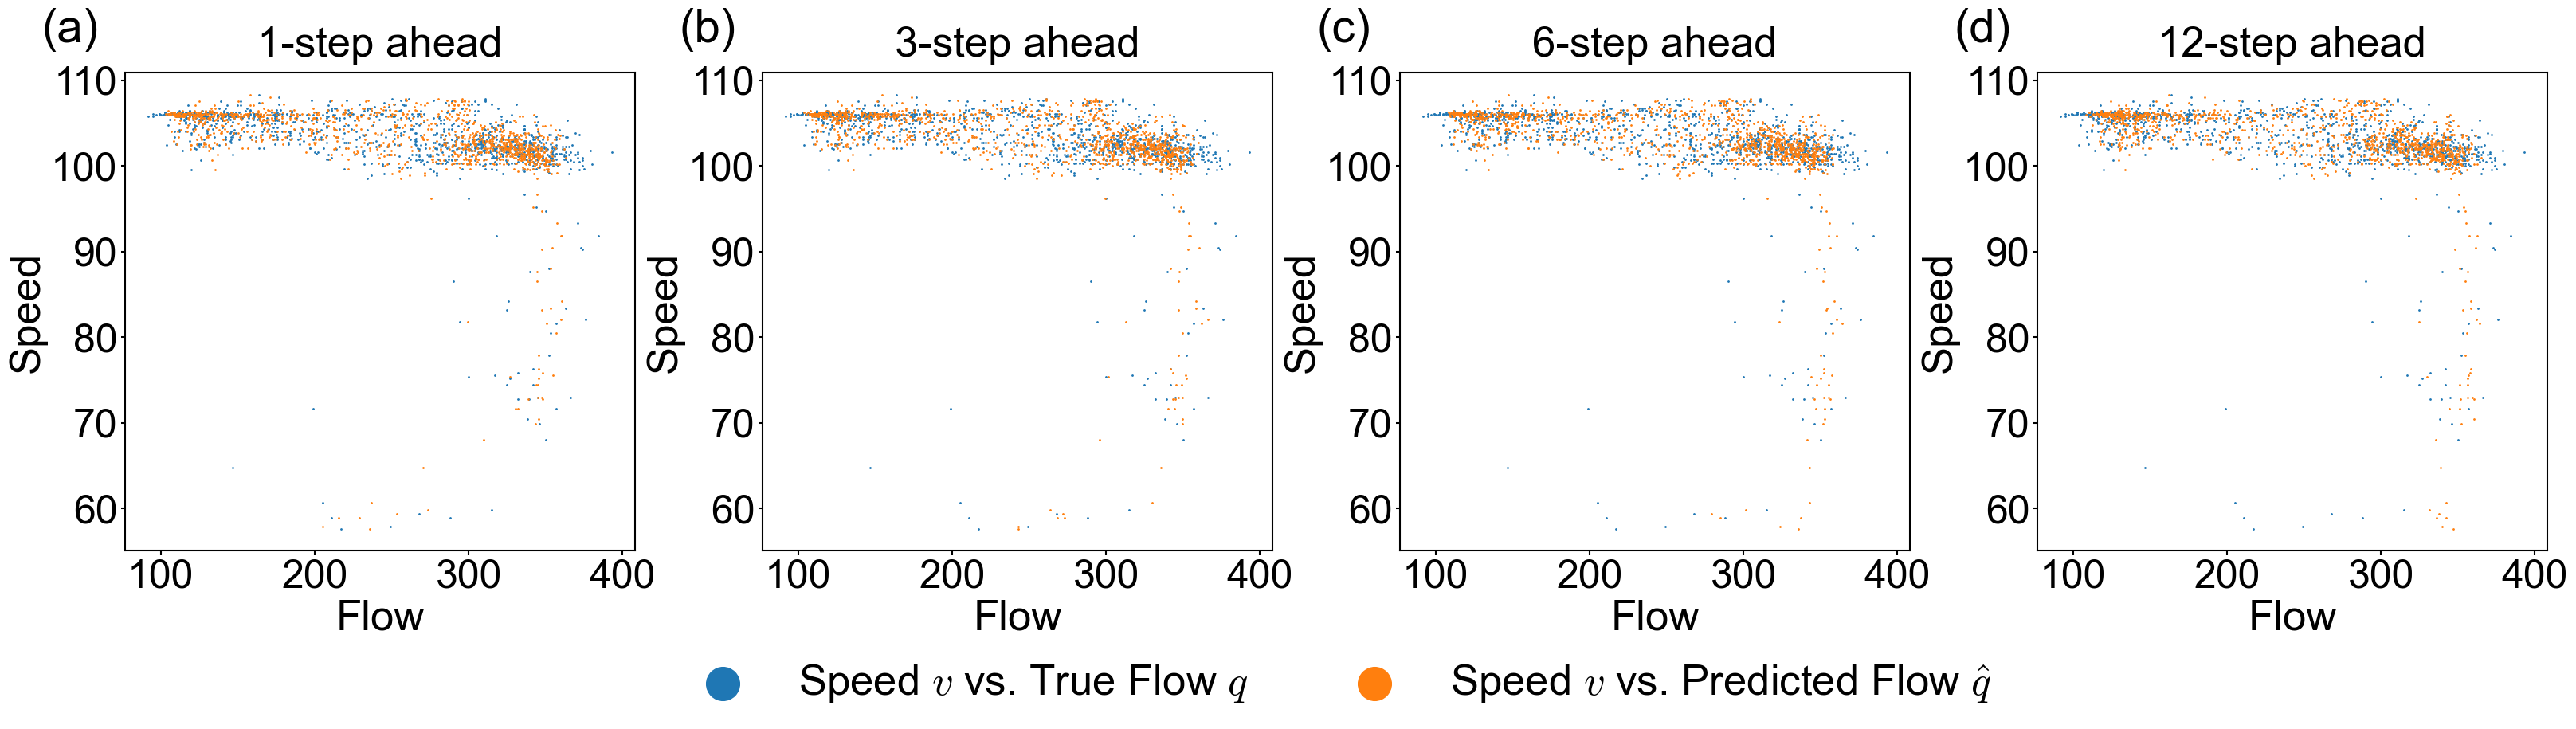

In [ ]:
font_addup=18
params = {'figure.titlesize':20+font_addup,
         'legend.fontsize':20+font_addup,
         'axes.labelsize':20+font_addup,
         'axes.titlesize':20+font_addup,
         'axes.linewidth':1.5,
         'xtick.labelsize':18+font_addup,
         'ytick.labelsize':18+font_addup,
         'xtick.major.width':1.5,
         'ytick.major.width':1.5,
         'font.family':'sans-serif',
         'font.sans-serif':'Arial',
         'mathtext.fontset':'cm'}
pylab.rcParams.update(params)


s_id = 30
idx = holiday_idx

nrow = 1
ncol = 4

labels = ["(a)", "(b)", "(c)", "(d)"]
f_steps = [0, 2, 5, 11]
fig = plt.figure(figsize=(38, 12))
trans = mtransforms.ScaledTranslation(-1.05, 19/72, fig.dpi_scale_trans)

gs = gridspec.GridSpec(nrow, ncol,
         wspace=0.25, hspace=0.45,
         top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1),
         left=0.5/(ncol+1), right=1-0.5/(ncol+1))

pos = 0
for i in range(nrow):
    for j in range(ncol):
        ax = plt.subplot(gs[i,j])
        f_step = f_steps[pos]

        ax.scatter(flow_np[idx,f_step,s_id], spd_np[idx,f_step,s_id], s=1, label=r"Speed $v$ vs. True Flow $q$")
        ax.scatter(flow_hat_np[idx,f_step,s_id], spd_np[idx,f_step,s_id], s=1, label=r"Speed $v$ vs. Predicted Flow $\hat{q}$")

        ax.set_title(r'%s-step ahead'%(f_step+1), pad=15)
        ax.set(xlabel=r'Flow', ylabel=r'Speed')
        ax.text(0.0, 1.0, labels[pos], transform=ax.transAxes+trans, fontsize=42, va='bottom')

        # ax.legend(frameon=False)

        pos += 1


handles, labels = ax.get_legend_handles_labels()

# for handle in handles:
#     handle.set_sizes([100])

fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, 0.05), frameon=False, markerscale=30)

# fig.savefig("figs/gwave_pm08_workdaynorush.pdf", bbox_inches='tight', dpi=300)
# fig.savefig("figs/gwave_pm08_workdayrush.pdf", bbox_inches='tight', dpi=300)
fig.savefig("figs/gwave_pm08_holiday.pdf", bbox_inches='tight', dpi=300)